In [2]:
# Sources
# https://python-chess.readthedocs.io/en/latest/
# https://github.com/rogerfitz/tutorials/tree/master/python_chess

#Read:
#https://onlinelibrary.wiley.com/doi/10.1002/asmb.2684

     -------------------------------------- 149.1/149.1 kB 3.0 MB/s eta 0:00:00


In [1]:
!pip install chess
!pip install Stockfish


                                              0.0/149.1 kB ? eta -:--:--
     -------------------------------        122.9/149.1 kB 3.6 MB/s eta 0:00:01
     -------------------------------------- 149.1/149.1 kB 2.2 MB/s eta 0:00:00


In [1]:
import chess.pgn
import pandas as pd
pd.options.display.max_columns=999
import datetime
import tqdm
import zipfile
import re

In [2]:
from stockfish import Stockfish
import chess
import chess.engine
import chess.svg
import chess.pgn
import re
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import matplotlib.pyplot as plt
import pickle
%matplotlib inline



In [3]:
# NUM_GAMES= 1000
# rows=[]

# with open(f'data/general_games.pgn') as pgn:
#     for game in tqdm.tqdm(range(NUM_GAMES)):
#         row={}
#         game = chess.pgn.read_game(pgn)
#         row['headers']=game.headers.__dict__
#         row['moves']=[x.uci() for x in game.mainline_moves()]
#         rows.append(row)
# games=pd.DataFrame(rows)
# games
# games.to_csv("data/general.csv",index=False)


In [4]:
def replace_numbers(string):
    pattern = r'\d'  # Matches any digit
    result = re.sub(pattern, lambda match: 'X' * int(match.group()), string)
    return result
def get_piece_position(fen, piece):
    # Split the FEN string into its components
    fen_parts = fen.split(' ')
    
    # Extract the board position part of the FEN
    board_fen = fen_parts[0]
    
    # Remove the slashes (/) to get a string of all the pieces
    board_fen = board_fen.replace('/', '')
    board_fen = replace_numbers(board_fen)    #Find the index of the knight (N) in the string
    indices = []
    for index, char in enumerate(board_fen):
        if char == piece:
            indices.append(index)
            break
            
    # Calculate the row and column based on the index
    try:
        row = 7 - (indices[0] // 8)
        column = indices[0] % 8
        return row, column
    except:
        return -1, -1

def save_list(list_save, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(list_save, file)

def load_list(file_path):
    with open(file_path, 'rb') as file:
        chess_data = pickle.load(file)
    return chess_data
# Example usage
fen = "rnbqkbnr/pppppppN/8/8/8/8/PPNPPPPP/RBNQKBNR w KQkq - 0 1"
knight_position = get_piece_position(fen, "N")
print("Knight Position: ", knight_position)

Knight Position:  (6, 7)


In [5]:
games=pd.read_csv("data/general.csv")
games['moves']=games['moves'].apply(lambda x: eval(x))
#games['headers']=games['headers'].apply(lambda x: eval(x))#to dict
games

,headers,moves
0,"{'_tag_roster': {'Event': '?', 'Site': '?', 'D...","[e2e4, e7e6, d2d4, d7d5, b1c3, f8b4, e4e5, g8e..."
1,{'_tag_roster': {'Event': 'Skopje Solidarnost-...,"[c2c4, g8f6, b1c3, e7e6, g1f3, f8b4, d1c2, c7c..."
2,{'_tag_roster': {'Event': 'Skopje Solidarnost-...,"[c2c4, g8f6, b1c3, d7d5, c4d5, f6d5, g2g3, g7g..."
3,"{'_tag_roster': {'Event': 'Yerevan', 'Site': '...","[g1f3, c7c5, g2g3, b7b5, a2a4, b5a4, f1g2, c8b..."
4,"{'_tag_roster': {'Event': 'URS Team-Cup09', 'S...","[g1f3, g7g6, e2e4, d7d6, d2d4, g8f6, b1c3, f8g..."
...,...,...
994,{'_tag_roster': {'Event': 'FRA-chT Top 16 Gp H...,"[d2d4, d7d5, c2c4, e7e6, b1c3, f8b4, g1f3, g8f..."
995,"{'_tag_roster': {'Event': 'BIH-chT', 'Site': '...","[e2e4, c7c5, g1f3, b8c6, d2d4, c5d4, f3d4, g8f..."
996,"{'_tag_roster': {'Event': 'BIH-chT', 'Site': '...","[d2d4, g8f6, c2c4, e7e6, g1f3, b7b6, g2g3, c8b..."
997,"{'_tag_roster': {'Event': 'BIH-chT', 'Site': '...","[e2e4, c7c5, g1f3, b8c6, b1c3, e7e5, f1c4, d7d..."


In [6]:
# df[a][b][c][d] = array of CPL of piece a at location (b, c) of color d
#0 = knight, 1, a, white
#df = np.zeros((2, 8, 8,2,1,), dtype=float)
# df = [[[[[0]] * 2] * 8] * 8] * 2
# #df
# # df = np.arange(256)
# # df = np.reshape(df, (2, 8, 8,2,1))
# df[0][0][0][0]
# df[1][7][7][1]

In [7]:
engine = Stockfish("stockfish-windows-2022-x86-64-avx2.exe")
engine.set_depth(20)
engine.set_skill_level(20)
board=chess.Board()


In [8]:
pieces = ['N', 'n', 'B', 'b']

In [9]:
df = [[[[[0] for _ in range(2)] for _ in range(8)] for _ in range(8)] for _ in range(2)]


In [10]:
df[1][7][7][1]

[0]

In [14]:
import pandas as pd

columns = ['piece', 'color', 'row', 'column', 'cpl']
chess_df = pd.DataFrame(columns=columns)
print(chess_df)


Empty DataFrame
Columns: [piece, color, row, column, cpl]
Index: []


In [15]:
import pandas as pd

for i in tqdm.tqdm(range(0, 1000)):
    try:
        board = chess.Board()
        curr_game = games.iloc[i]
        print(curr_game['moves'][0])
        for move_number, san in enumerate(curr_game['moves']):
            move = board.push_san(san)
            engine.set_fen_position(board.fen())
            evaluation = engine.get_evaluation()
            data = {'piece': [], 'color': [], 'row': [], 'column': [], 'cpl': []}
            for index, piece in enumerate(pieces):
                row, column = get_piece_position(board.fen(), piece)
                if row == -1:
                    continue
                if i % 100 == 0:
                    print(board.fen())
                    print(evaluation)
                data['piece'].append(int(index / 2))
                data['color'].append(index % 2)
                data['row'].append(row)
                data['column'].append(column)
                data['cpl'].append(evaluation['value'])
            chess_df = pd.concat([chess_df, pd.DataFrame(data)], ignore_index=True)
        if i % 100 == 0:
            chess_df.to_csv('data/general_final_' + str(int(i/100)) + '.csv', index=False)
    except Exception as e:
        print("An exception occurred:", str(e))
        continue


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

e2e4
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 47}
rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 47}
rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 47}
rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 47}
rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2
{'type': 'cp', 'value': 43}
rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2
{'type': 'cp', 'value': 43}
rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2
{'type': 'cp', 'value': 43}
rnbqkbnr/pppp1ppp/4p3/8/

r4rk1/pp1bnppp/2n1p3/q2pP1N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 b - - 3 12
{'type': 'cp', 'value': 55}
r4rk1/pp1bnppp/2n1p3/q2pP1N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 b - - 3 12
{'type': 'cp', 'value': 55}
r4rk1/pp1bnppp/2n1p3/q2pP1N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 b - - 3 12
{'type': 'cp', 'value': 55}
r4rk1/pp1bnppp/2n1p3/q2pP1N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 b - - 3 12
{'type': 'cp', 'value': 55}
r4rk1/pp1bn1pp/2n1pp2/q2pP1N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 w - - 0 13
{'type': 'cp', 'value': 59}
r4rk1/pp1bn1pp/2n1pp2/q2pP1N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 w - - 0 13
{'type': 'cp', 'value': 59}
r4rk1/pp1bn1pp/2n1pp2/q2pP1N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 w - - 0 13
{'type': 'cp', 'value': 59}
r4rk1/pp1bn1pp/2n1pp2/q2pP1N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 w - - 0 13
{'type': 'cp', 'value': 59}
r4rk1/pp1bn1pp/2n1pP2/q2p2N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 b - - 0 13
{'type': 'cp', 'value': 55}
r4rk1/pp1bn1pp/2n1pP2/q2p2N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 b - - 0 13
{'type': 'cp', 'value': 55}
r4rk1/pp1bn1pp/2n1pP2/q2p2N1/P1pP4/2P5/2PBBPPP/R2Q1RK1 b

R1bn1rk1/1p1n2p1/4pr1p/1q1pN3/2pP2B1/2P5/2PB1PPP/2Q1R1K1 b - - 4 23
{'type': 'cp', 'value': 170}
R1bn1rk1/1p1n2p1/4pr1p/1q1pN3/2pP2B1/2P5/2PB1PPP/2Q1R1K1 b - - 4 23
{'type': 'cp', 'value': 170}
R1bn1rk1/1p1n2p1/4pr1p/1q1pN3/2pP2B1/2P5/2PB1PPP/2Q1R1K1 b - - 4 23
{'type': 'cp', 'value': 170}
R1bn1rk1/1p1n2p1/4pr1p/1q1pN3/2pP2B1/2P5/2PB1PPP/2Q1R1K1 b - - 4 23
{'type': 'cp', 'value': 170}
R1bn1rk1/1p4p1/1n2pr1p/1q1pN3/2pP2B1/2P5/2PB1PPP/2Q1R1K1 w - - 5 24
{'type': 'cp', 'value': 177}
R1bn1rk1/1p4p1/1n2pr1p/1q1pN3/2pP2B1/2P5/2PB1PPP/2Q1R1K1 w - - 5 24
{'type': 'cp', 'value': 177}
R1bn1rk1/1p4p1/1n2pr1p/1q1pN3/2pP2B1/2P5/2PB1PPP/2Q1R1K1 w - - 5 24
{'type': 'cp', 'value': 177}
R1bn1rk1/1p4p1/1n2pr1p/1q1pN3/2pP2B1/2P5/2PB1PPP/2Q1R1K1 w - - 5 24
{'type': 'cp', 'value': 177}
2bn1rk1/1p4p1/1n2pr1p/1q1pN3/2pP2B1/2P5/2PB1PPP/R1Q1R1K1 b - - 6 24
{'type': 'cp', 'value': 167}
2bn1rk1/1p4p1/1n2pr1p/1q1pN3/2pP2B1/2P5/2PB1PPP/R1Q1R1K1 b - - 6 24
{'type': 'cp', 'value': 167}
2bn1rk1/1p4p1/1n2pr1p/1q1pN3/2

2b1r1r1/1p1n4/2q1p1k1/3pB1p1/2pP2B1/2P2P2/2P3P1/R1Q1R1K1 w - - 4 36
{'type': 'cp', 'value': 302}
2b1r1r1/1p1n4/2q1p1k1/3pB1p1/2pP2B1/2P2P2/2P3P1/R1Q1R1K1 w - - 4 36
{'type': 'cp', 'value': 302}
2b1r1r1/1p1n4/2q1p1k1/3pB1p1/2pP2B1/2P2P2/2P3P1/R1Q1R1K1 w - - 4 36
{'type': 'cp', 'value': 302}
2b1r1r1/1p1n4/2q1p1k1/3pB1p1/2pP2B1/2P2PP1/2P5/R1Q1R1K1 b - - 0 36
{'type': 'cp', 'value': 199}
2b1r1r1/1p1n4/2q1p1k1/3pB1p1/2pP2B1/2P2PP1/2P5/R1Q1R1K1 b - - 0 36
{'type': 'cp', 'value': 199}
2b1r1r1/1p1n4/2q1p1k1/3pB1p1/2pP2B1/2P2PP1/2P5/R1Q1R1K1 b - - 0 36
{'type': 'cp', 'value': 199}
2b3r1/1p1nr3/2q1p1k1/3pB1p1/2pP2B1/2P2PP1/2P5/R1Q1R1K1 w - - 1 37
{'type': 'cp', 'value': 237}
2b3r1/1p1nr3/2q1p1k1/3pB1p1/2pP2B1/2P2PP1/2P5/R1Q1R1K1 w - - 1 37
{'type': 'cp', 'value': 237}
2b3r1/1p1nr3/2q1p1k1/3pB1p1/2pP2B1/2P2PP1/2P5/R1Q1R1K1 w - - 1 37
{'type': 'cp', 'value': 237}
2b3r1/1p1nr3/2q1p1k1/3pB1p1/2pP1PB1/2P3P1/2P5/R1Q1R1K1 b - - 0 37
{'type': 'cp', 'value': 227}
2b3r1/1p1nr3/2q1p1k1/3pB1p1/2pP1PB1/2P3P1

  0%|                                                                             | 1/1000 [01:41<28:15:03, 101.80s/it]

R3B3/1p1b3R/3kp3/3p4/2pP4/2P5/2PK4/6q1 b - - 13 53
{'type': 'cp', 'value': 0}
R3B3/1p1b3R/3kp3/3p4/2pP4/2P5/2PK4/6q1 b - - 13 53
{'type': 'cp', 'value': 0}
c2c4


  0%|▏                                                                            | 2/1000 [03:59<34:01:55, 122.76s/it]

c2c4


  0%|▏                                                                            | 3/1000 [05:52<32:45:26, 118.28s/it]

g1f3


  0%|▎                                                                            | 4/1000 [07:40<31:40:42, 114.50s/it]

g1f3


  0%|▍                                                                             | 5/1000 [08:36<25:49:08, 93.42s/it]

e2e4


  1%|▍                                                                             | 6/1000 [09:18<20:58:23, 75.96s/it]

e2e4


  1%|▌                                                                             | 7/1000 [09:50<16:58:53, 61.56s/it]

e2e4


  1%|▌                                                                             | 8/1000 [10:12<13:26:58, 48.81s/it]

e2e4


  1%|▋                                                                             | 9/1000 [12:01<18:36:14, 67.58s/it]

g1f3


  1%|▊                                                                            | 10/1000 [12:25<14:52:01, 54.06s/it]

e2e4


  1%|▊                                                                            | 11/1000 [13:09<14:02:16, 51.10s/it]

e2e4


  1%|▉                                                                            | 12/1000 [14:27<16:15:32, 59.24s/it]

e2e4


  1%|█                                                                            | 13/1000 [15:12<15:02:02, 54.84s/it]

g1f3


  1%|█                                                                            | 14/1000 [17:14<20:37:42, 75.32s/it]

c2c4


  2%|█▏                                                                           | 15/1000 [18:27<20:25:49, 74.67s/it]

e2e4


  2%|█▏                                                                           | 16/1000 [19:59<21:46:39, 79.67s/it]

c2c4


  2%|█▎                                                                           | 17/1000 [21:31<22:49:09, 83.57s/it]

e2e4


  2%|█▍                                                                           | 18/1000 [22:44<21:56:08, 80.42s/it]

d2d4


  2%|█▍                                                                           | 19/1000 [23:40<19:54:26, 73.05s/it]

e2e4


  2%|█▌                                                                           | 20/1000 [24:37<18:34:02, 68.21s/it]

e2e4


  2%|█▌                                                                           | 21/1000 [26:05<20:10:46, 74.21s/it]

e2e4


  2%|█▋                                                                           | 22/1000 [27:26<20:43:35, 76.29s/it]

e2e4


  2%|█▊                                                                           | 23/1000 [28:39<20:22:27, 75.07s/it]

e2e4


  2%|█▊                                                                           | 24/1000 [29:15<17:09:35, 63.29s/it]

g1f3


  2%|█▉                                                                           | 25/1000 [30:19<17:13:29, 63.60s/it]

c2c4


  3%|██                                                                           | 26/1000 [30:45<14:10:17, 52.38s/it]

g1f3


  3%|██                                                                           | 27/1000 [32:28<18:15:17, 67.54s/it]

d2d4


  3%|██▏                                                                          | 28/1000 [33:56<19:56:08, 73.84s/it]

e2e4


  3%|██▏                                                                          | 29/1000 [34:55<18:39:11, 69.16s/it]

d2d4


  3%|██▎                                                                          | 30/1000 [35:36<16:23:51, 60.86s/it]

d2d4


  3%|██▍                                                                          | 31/1000 [36:57<17:57:45, 66.73s/it]

c2c4


  3%|██▍                                                                          | 32/1000 [37:13<13:50:31, 51.48s/it]

e2e4


  3%|██▌                                                                          | 33/1000 [38:32<16:02:58, 59.75s/it]

e2e4


  3%|██▌                                                                          | 34/1000 [39:01<13:36:18, 50.70s/it]

e2e4


  4%|██▋                                                                          | 35/1000 [39:25<11:27:02, 42.72s/it]

e2e4


  4%|██▊                                                                           | 36/1000 [39:46<9:42:10, 36.23s/it]

e2e4


  4%|██▉                                                                           | 37/1000 [40:05<8:15:12, 30.85s/it]

d2d4


  4%|██▉                                                                           | 38/1000 [40:55<9:46:22, 36.57s/it]

g1f3


  4%|███                                                                          | 39/1000 [41:54<11:33:30, 43.30s/it]

e2e4


  4%|███                                                                          | 40/1000 [42:50<12:34:19, 47.15s/it]

g1f3


  4%|███▏                                                                         | 41/1000 [43:26<11:39:08, 43.74s/it]

e2e4


  4%|███▏                                                                         | 42/1000 [44:19<12:25:46, 46.71s/it]

d2d4


  4%|███▎                                                                         | 43/1000 [45:02<12:07:36, 45.62s/it]

e2e4


  4%|███▍                                                                         | 44/1000 [46:08<13:41:25, 51.55s/it]

e2e4


  4%|███▍                                                                         | 45/1000 [46:38<12:00:34, 45.27s/it]

g1f3


  5%|███▌                                                                         | 46/1000 [46:59<10:03:21, 37.95s/it]

d2d4


  5%|███▌                                                                         | 47/1000 [47:48<10:55:20, 41.26s/it]

d2d4


  5%|███▋                                                                         | 48/1000 [48:32<11:09:38, 42.20s/it]

c2c4


  5%|███▊                                                                         | 49/1000 [49:29<12:17:17, 46.52s/it]

d2d4


  5%|███▊                                                                         | 50/1000 [50:10<11:49:18, 44.80s/it]

d2d4


  5%|███▉                                                                         | 51/1000 [51:09<12:58:21, 49.21s/it]

e2e4


  5%|████                                                                         | 52/1000 [52:33<15:39:02, 59.43s/it]

e2e4


  5%|████                                                                         | 53/1000 [53:02<13:17:02, 50.50s/it]

c2c4


  5%|████▏                                                                        | 54/1000 [54:02<13:58:09, 53.16s/it]

c2c4


  6%|████▏                                                                        | 55/1000 [54:53<13:50:45, 52.75s/it]

g1f3


  6%|████▎                                                                        | 56/1000 [55:25<12:09:36, 46.37s/it]

g1f3


  6%|████▍                                                                        | 57/1000 [56:27<13:23:03, 51.10s/it]

e2e4


  6%|████▍                                                                        | 58/1000 [58:12<17:33:30, 67.10s/it]

e2e4


  6%|████▌                                                                        | 59/1000 [58:57<15:52:33, 60.74s/it]

e2e4


  6%|████▌                                                                        | 60/1000 [59:46<14:52:07, 56.94s/it]

g1f3


  6%|████▌                                                                      | 61/1000 [1:01:05<16:36:17, 63.66s/it]

e2e4


  6%|████▋                                                                      | 62/1000 [1:02:09<16:37:36, 63.81s/it]

g1f3


  6%|████▋                                                                      | 63/1000 [1:03:24<17:27:03, 67.05s/it]

d2d4


  6%|████▊                                                                      | 64/1000 [1:04:16<16:18:13, 62.71s/it]

c2c4


  6%|████▉                                                                      | 65/1000 [1:05:22<16:32:49, 63.71s/it]

d2d4


  7%|████▉                                                                      | 66/1000 [1:06:40<17:39:35, 68.07s/it]

d2d4


  7%|█████                                                                      | 67/1000 [1:08:00<18:29:45, 71.37s/it]

e2e4


  7%|█████                                                                      | 68/1000 [1:09:09<18:19:50, 70.81s/it]

c2c4


  7%|█████▏                                                                     | 69/1000 [1:10:16<18:01:20, 69.69s/it]

e2e4


  7%|█████▎                                                                     | 70/1000 [1:11:31<18:23:58, 71.22s/it]

e2e4


  7%|█████▎                                                                     | 71/1000 [1:12:54<19:15:44, 74.64s/it]

e2e4


  7%|█████▍                                                                     | 72/1000 [1:14:02<18:48:04, 72.94s/it]

d2d4


  7%|█████▍                                                                     | 73/1000 [1:14:50<16:48:39, 65.29s/it]

e2e4


  7%|█████▌                                                                     | 74/1000 [1:16:40<20:15:47, 78.78s/it]

e2e4


  8%|█████▋                                                                     | 75/1000 [1:17:20<17:14:12, 67.08s/it]

c2c4


  8%|█████▋                                                                     | 76/1000 [1:18:27<17:13:05, 67.08s/it]

c2c4


  8%|█████▊                                                                     | 77/1000 [1:20:56<23:31:29, 91.75s/it]

c2c4


  8%|█████▊                                                                     | 78/1000 [1:21:27<18:49:14, 73.49s/it]

e2e4


  8%|█████▉                                                                     | 79/1000 [1:22:58<20:07:12, 78.65s/it]

e2e4


  8%|██████                                                                     | 80/1000 [1:24:10<19:36:01, 76.70s/it]

d2d4


  8%|██████                                                                     | 81/1000 [1:25:10<18:18:08, 71.70s/it]

e2e4


  8%|██████▏                                                                    | 82/1000 [1:26:33<19:09:10, 75.11s/it]

e2e4


  8%|██████▏                                                                    | 83/1000 [1:27:30<17:43:46, 69.60s/it]

e2e4


  8%|██████▎                                                                    | 84/1000 [1:28:32<17:09:49, 67.46s/it]

g1f3


  8%|██████▍                                                                    | 85/1000 [1:28:48<13:13:15, 52.02s/it]

e2e4


  9%|██████▍                                                                    | 86/1000 [1:29:09<10:48:55, 42.60s/it]

e2e4


  9%|██████▌                                                                    | 87/1000 [1:31:01<16:07:09, 63.56s/it]

d2d4


  9%|██████▌                                                                    | 88/1000 [1:32:29<17:53:14, 70.61s/it]

d2d4


  9%|██████▋                                                                    | 89/1000 [1:33:09<15:36:50, 61.70s/it]

e2e4


  9%|██████▊                                                                    | 90/1000 [1:33:37<13:02:27, 51.59s/it]

d2d4


  9%|██████▊                                                                    | 91/1000 [1:34:00<10:48:17, 42.79s/it]

e2e4


  9%|██████▉                                                                    | 92/1000 [1:35:11<12:55:57, 51.27s/it]

g1f3


  9%|██████▉                                                                    | 93/1000 [1:35:52<12:10:48, 48.34s/it]

d2d4


  9%|███████                                                                    | 94/1000 [1:36:42<12:14:33, 48.65s/it]

e2e4


 10%|███████▏                                                                   | 95/1000 [1:37:16<11:09:18, 44.37s/it]

e2e4


 10%|███████▏                                                                   | 96/1000 [1:37:59<11:02:54, 44.00s/it]

d2d4


 10%|███████▎                                                                   | 97/1000 [1:39:33<14:45:55, 58.87s/it]

d2d4


 10%|███████▎                                                                   | 98/1000 [1:40:13<13:20:43, 53.26s/it]

g1f3


 10%|███████▍                                                                   | 99/1000 [1:40:32<10:44:30, 42.92s/it]

d2d4


 10%|███████▌                                                                   | 100/1000 [1:41:03<9:52:30, 39.50s/it]

d2d4
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppp1ppp/4p3/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/4p3/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/4p3/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/4p3/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/4p3/8/3P4/5N2/PPP1PPPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 39}
rnbqkbnr/pppp1ppp/4p3/8/3P4/5N2/PPP1PPPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 39}
rnbqkbnr/pppp1ppp/4p3/8/3P4/5N2/PPP1PPPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 39}
rnbqkbnr/pppp1ppp/

r1b2rk1/5ppp/ppNqpn2/2pp4/3P1P2/2NB4/PPPQ1PPP/R3R1K1 b - - 0 12
{'type': 'cp', 'value': -12}
r1b2rk1/5ppp/ppNqpn2/2pp4/3P1P2/2NB4/PPPQ1PPP/R3R1K1 b - - 0 12
{'type': 'cp', 'value': -12}
r1b2rk1/5ppp/ppNqpn2/2pp4/3P1P2/2NB4/PPPQ1PPP/R3R1K1 b - - 0 12
{'type': 'cp', 'value': -12}
r1b2rk1/5ppp/ppNqpn2/2pp4/3P1P2/2NB4/PPPQ1PPP/R3R1K1 b - - 0 12
{'type': 'cp', 'value': -12}
r1b2rk1/5ppp/ppq1pn2/2pp4/3P1P2/2NB4/PPPQ1PPP/R3R1K1 w - - 0 13
{'type': 'cp', 'value': -5}
r1b2rk1/5ppp/ppq1pn2/2pp4/3P1P2/2NB4/PPPQ1PPP/R3R1K1 w - - 0 13
{'type': 'cp', 'value': -5}
r1b2rk1/5ppp/ppq1pn2/2pp4/3P1P2/2NB4/PPPQ1PPP/R3R1K1 w - - 0 13
{'type': 'cp', 'value': -5}
r1b2rk1/5ppp/ppq1pn2/2pp4/3P1P2/2NB4/PPPQ1PPP/R3R1K1 w - - 0 13
{'type': 'cp', 'value': -5}
r1b2rk1/5ppp/ppq1pn2/2pp4/3P1P2/2NBQ3/PPP2PPP/R3R1K1 b - - 1 13
{'type': 'cp', 'value': -31}
r1b2rk1/5ppp/ppq1pn2/2pp4/3P1P2/2NBQ3/PPP2PPP/R3R1K1 b - - 1 13
{'type': 'cp', 'value': -31}
r1b2rk1/5ppp/ppq1pn2/2pp4/3P1P2/2NBQ3/PPP2PPP/R3R1K1 b - - 1 13
{'type': '

r3r1k1/6pp/3qpn2/pp1p1p2/2pP1P2/P1P2NP1/1PQ2P1P/R3R1K1 b - - 3 25
{'type': 'cp', 'value': -29}
r3r1k1/6pp/3qpn2/pp1p1p2/2pP1P2/P1P2NP1/1PQ2P1P/R3R1K1 b - - 3 25
{'type': 'cp', 'value': -29}
4r1k1/6pp/r2qpn2/pp1p1p2/2pP1P2/P1P2NP1/1PQ2P1P/R3R1K1 w - - 4 26
{'type': 'cp', 'value': -3}
4r1k1/6pp/r2qpn2/pp1p1p2/2pP1P2/P1P2NP1/1PQ2P1P/R3R1K1 w - - 4 26
{'type': 'cp', 'value': -3}
4r1k1/6pp/r2qpn2/pp1pNp2/2pP1P2/P1P3P1/1PQ2P1P/R3R1K1 b - - 5 26
{'type': 'cp', 'value': -4}
4r1k1/6pp/r2qpn2/pp1pNp2/2pP1P2/P1P3P1/1PQ2P1P/R3R1K1 b - - 5 26
{'type': 'cp', 'value': -4}
4r1k1/3n2pp/r2qp3/pp1pNp2/2pP1P2/P1P3P1/1PQ2P1P/R3R1K1 w - - 6 27
{'type': 'cp', 'value': 29}
4r1k1/3n2pp/r2qp3/pp1pNp2/2pP1P2/P1P3P1/1PQ2P1P/R3R1K1 w - - 6 27
{'type': 'cp', 'value': 29}
4r1k1/3N2pp/r2qp3/pp1p1p2/2pP1P2/P1P3P1/1PQ2P1P/R3R1K1 b - - 0 27
{'type': 'cp', 'value': 28}


 10%|███████▍                                                                  | 101/1000 [1:42:52<15:01:17, 60.15s/it]

d2d4


 10%|███████▌                                                                  | 102/1000 [1:44:17<16:53:26, 67.71s/it]

d2d4


 10%|███████▌                                                                  | 103/1000 [1:45:27<17:04:03, 68.50s/it]

e2e4


 10%|███████▋                                                                  | 104/1000 [1:46:56<18:32:36, 74.51s/it]

c2c4


 10%|███████▊                                                                  | 105/1000 [1:47:49<16:56:45, 68.16s/it]

g2g3


 11%|███████▊                                                                  | 106/1000 [1:48:08<13:17:17, 53.51s/it]

g1f3


 11%|███████▉                                                                  | 107/1000 [1:48:41<11:43:13, 47.25s/it]

d2d4


 11%|███████▉                                                                  | 108/1000 [1:49:11<10:23:29, 41.94s/it]

d2d4


 11%|████████                                                                  | 109/1000 [1:49:48<10:03:58, 40.67s/it]

d2d4


 11%|████████▏                                                                 | 110/1000 [1:50:32<10:16:14, 41.54s/it]

d2d4


 11%|████████▏                                                                 | 111/1000 [1:53:54<22:07:28, 89.59s/it]

e2e4


 11%|████████▎                                                                 | 112/1000 [1:54:54<19:55:49, 80.80s/it]

g1f3


 11%|████████▎                                                                 | 113/1000 [1:55:42<17:29:51, 71.02s/it]

e2e4


 11%|████████▍                                                                 | 114/1000 [1:56:34<16:02:16, 65.17s/it]

d2d4


 12%|████████▌                                                                 | 115/1000 [1:57:58<17:27:36, 71.02s/it]

d2d4


 12%|████████▌                                                                 | 116/1000 [1:59:22<18:22:28, 74.83s/it]

g1f3


 12%|████████▋                                                                 | 117/1000 [2:00:27<17:38:10, 71.90s/it]

d2d4


 12%|████████▋                                                                 | 118/1000 [2:01:03<14:56:23, 60.98s/it]

g1f3


 12%|████████▊                                                                 | 119/1000 [2:01:44<13:29:07, 55.10s/it]

d2d4


 12%|████████▉                                                                 | 120/1000 [2:02:54<14:32:34, 59.49s/it]

e2e4


 12%|████████▉                                                                 | 121/1000 [2:04:11<15:50:05, 64.85s/it]

d2d4


 12%|█████████                                                                 | 122/1000 [2:05:29<16:46:18, 68.77s/it]

d2d4


 12%|█████████                                                                 | 123/1000 [2:06:16<15:09:25, 62.22s/it]

d2d4


 12%|█████████▏                                                                | 124/1000 [2:06:50<13:04:13, 53.71s/it]

e2e4


 12%|█████████▎                                                                | 125/1000 [2:07:52<13:38:57, 56.16s/it]

c2c4


 13%|█████████▎                                                                | 126/1000 [2:08:45<13:24:07, 55.20s/it]

e2e4


 13%|█████████▍                                                                | 127/1000 [2:09:44<13:41:15, 56.44s/it]

d2d4


 13%|█████████▍                                                                | 128/1000 [2:10:12<11:36:11, 47.90s/it]

c2c4


 13%|█████████▌                                                                | 129/1000 [2:11:25<13:26:02, 55.53s/it]

d2d4


 13%|█████████▌                                                                | 130/1000 [2:11:44<10:44:49, 44.47s/it]

d2d4


 13%|█████████▋                                                                | 131/1000 [2:12:49<12:12:31, 50.58s/it]

d2d4


 13%|█████████▊                                                                | 132/1000 [2:13:37<11:59:36, 49.74s/it]

d2d4


 13%|█████████▊                                                                | 133/1000 [2:14:42<13:06:24, 54.42s/it]

d2d4


 13%|█████████▉                                                                | 134/1000 [2:14:56<10:11:46, 42.39s/it]

e2e4


 14%|██████████▏                                                                | 135/1000 [2:15:35<9:56:25, 41.37s/it]

g1f3


 14%|██████████▏                                                                | 136/1000 [2:16:05<9:04:55, 37.84s/it]

d2d4


 14%|██████████▎                                                                | 137/1000 [2:16:36<8:37:37, 35.99s/it]

d2d4


 14%|██████████▏                                                               | 138/1000 [2:18:04<12:20:59, 51.58s/it]

d2d4


 14%|██████████▎                                                               | 139/1000 [2:18:36<10:54:44, 45.63s/it]

d2d4


 14%|██████████▎                                                               | 140/1000 [2:20:00<13:40:05, 57.22s/it]

g1f3


 14%|██████████▍                                                               | 141/1000 [2:21:00<13:48:27, 57.87s/it]

e2e4


 14%|██████████▌                                                               | 142/1000 [2:21:56<13:41:05, 57.42s/it]

d2d4


 14%|██████████▌                                                               | 143/1000 [2:24:10<19:08:40, 80.42s/it]

e2e4


 14%|██████████▋                                                               | 144/1000 [2:24:44<15:46:49, 66.37s/it]

d2d4


 14%|██████████▋                                                               | 145/1000 [2:25:36<14:46:14, 62.19s/it]

c2c4


 15%|██████████▊                                                               | 146/1000 [2:25:55<11:37:31, 49.01s/it]

c2c4


 15%|██████████▉                                                               | 147/1000 [2:27:36<15:19:56, 64.71s/it]

d2d4


 15%|██████████▉                                                               | 148/1000 [2:29:00<16:41:35, 70.53s/it]

d2d4


 15%|███████████                                                               | 149/1000 [2:30:25<17:41:44, 74.86s/it]

d2d4


 15%|███████████                                                               | 150/1000 [2:31:09<15:27:41, 65.48s/it]

d2d4


 15%|███████████▏                                                              | 151/1000 [2:32:23<16:02:53, 68.05s/it]

d2d4


 15%|███████████▏                                                              | 152/1000 [2:32:58<13:44:45, 58.36s/it]

e2e4


 15%|███████████▎                                                              | 153/1000 [2:34:41<16:53:09, 71.77s/it]

e2e4


 15%|███████████▍                                                              | 154/1000 [2:35:25<14:54:02, 63.41s/it]

e2e4


 16%|███████████▍                                                              | 155/1000 [2:36:53<16:36:06, 70.73s/it]

d2d4


 16%|███████████▌                                                              | 156/1000 [2:37:37<14:42:08, 62.71s/it]

c2c4


 16%|███████████▌                                                              | 157/1000 [2:38:32<14:09:52, 60.49s/it]

e2e4


 16%|███████████▋                                                              | 158/1000 [2:39:33<14:11:17, 60.66s/it]

e2e4


 16%|███████████▊                                                              | 159/1000 [2:40:32<14:03:00, 60.14s/it]

d2d4


 16%|███████████▊                                                              | 160/1000 [2:41:23<13:21:00, 57.21s/it]

d2d4


 16%|███████████▉                                                              | 161/1000 [2:42:40<14:42:11, 63.09s/it]

e2e4


 16%|███████████▉                                                              | 162/1000 [2:42:58<11:34:58, 49.76s/it]

g1f3


 16%|████████████                                                              | 163/1000 [2:43:41<11:06:34, 47.78s/it]

d2d4


 16%|████████████▎                                                              | 164/1000 [2:43:58<8:54:40, 38.37s/it]

d2d4


 16%|████████████▍                                                              | 165/1000 [2:44:16<7:30:44, 32.39s/it]

c2c4


 17%|████████████▎                                                             | 166/1000 [2:45:45<11:25:58, 49.35s/it]

g1f3


 17%|████████████▎                                                             | 167/1000 [2:46:51<12:35:21, 54.41s/it]

g1f3


 17%|████████████▍                                                             | 168/1000 [2:47:52<13:00:23, 56.28s/it]

d2d4


 17%|████████████▌                                                             | 169/1000 [2:48:51<13:10:12, 57.05s/it]

d2d4


 17%|████████████▌                                                             | 170/1000 [2:49:35<12:17:01, 53.28s/it]

d2d4


 17%|████████████▋                                                             | 171/1000 [2:50:57<14:15:03, 61.89s/it]

e2e4


 17%|████████████▋                                                             | 172/1000 [2:51:32<12:20:03, 53.63s/it]

c2c4


 17%|████████████▊                                                             | 173/1000 [2:52:05<10:55:31, 47.56s/it]

d2d4


 17%|████████████▉                                                             | 174/1000 [2:52:55<11:03:41, 48.21s/it]

c2c4


 18%|████████████▉                                                             | 175/1000 [2:54:15<13:16:37, 57.94s/it]

d2d4


 18%|█████████████                                                             | 176/1000 [2:55:10<13:01:16, 56.89s/it]

e2e4


 18%|█████████████                                                             | 177/1000 [2:55:59<12:29:30, 54.64s/it]

e2e4


 18%|█████████████▏                                                            | 178/1000 [2:56:32<10:59:59, 48.17s/it]

e2e4


 18%|█████████████▏                                                            | 179/1000 [2:57:42<12:25:50, 54.51s/it]

e2e4


 18%|█████████████▎                                                            | 180/1000 [2:58:10<10:39:02, 46.76s/it]

d2d4


 18%|█████████████▌                                                             | 181/1000 [2:58:34<9:04:31, 39.89s/it]

d2d4


 18%|█████████████▍                                                            | 182/1000 [2:59:54<11:45:47, 51.77s/it]

c2c4


 18%|█████████████▌                                                            | 183/1000 [3:01:34<15:01:42, 66.22s/it]

e2e4


 18%|█████████████▌                                                            | 184/1000 [3:03:00<16:20:50, 72.12s/it]

d2d4


 18%|█████████████▋                                                            | 185/1000 [3:04:03<15:43:12, 69.44s/it]

d2d4


 19%|█████████████▊                                                            | 186/1000 [3:05:53<18:29:27, 81.78s/it]

d2d4


 19%|█████████████▊                                                            | 187/1000 [3:06:20<14:46:15, 65.41s/it]

g2g3


 19%|█████████████▉                                                            | 188/1000 [3:06:46<12:03:00, 53.42s/it]

d2d4


 19%|█████████████▉                                                            | 189/1000 [3:07:12<10:13:04, 45.36s/it]

e2e4


 19%|██████████████                                                            | 190/1000 [3:08:32<12:31:00, 55.63s/it]

e2e4


 19%|██████████████▎                                                            | 191/1000 [3:08:50<9:59:04, 44.43s/it]

e2e4


 19%|██████████████▏                                                           | 192/1000 [3:10:02<11:47:32, 52.54s/it]

d2d4


 19%|██████████████▎                                                           | 193/1000 [3:11:21<13:32:51, 60.44s/it]

e2e4


 19%|██████████████▎                                                           | 194/1000 [3:12:05<12:27:27, 55.64s/it]

g1f3


 20%|██████████████▍                                                           | 195/1000 [3:13:16<13:28:33, 60.26s/it]

d2d4


 20%|██████████████▌                                                           | 196/1000 [3:14:09<12:56:35, 57.95s/it]

e2e4


 20%|██████████████▌                                                           | 197/1000 [3:14:38<10:58:17, 49.19s/it]

d2d4


 20%|██████████████▋                                                           | 198/1000 [3:15:26<10:55:54, 49.07s/it]

e2e4


 20%|██████████████▋                                                           | 199/1000 [3:16:16<10:58:47, 49.35s/it]

d2d4


 20%|██████████████▊                                                           | 200/1000 [3:17:46<13:39:44, 61.48s/it]

c2c4
rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 24}
rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 24}
rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 24}
rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 24}
rnbqkbnr/pppp1ppp/8/4p3/2P5/8/PP1PPPPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 26}
rnbqkbnr/pppp1ppp/8/4p3/2P5/8/PP1PPPPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 26}
rnbqkbnr/pppp1ppp/8/4p3/2P5/8/PP1PPPPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 26}
rnbqkbnr/pppp1ppp/8/4p3/2P5/8/PP1PPPPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 26}
rnbqkbnr/pppp1ppp/8/4p3/2P5/2N5/PP1PPPPP/R1BQKBNR b KQkq - 1 2
{'type': 'cp', 'value': 29}
rnbqkbnr/pppp1ppp/8/4p3/2P5/2N5/PP1PPPPP/R1BQKBNR b KQkq - 1 2
{'type': 'cp', 'value': 29}
rnbqkbnr/pppp1ppp/8/4p3/2P5/2N5/PP1PPPPP/R1BQKBNR b KQkq - 1 2
{'type': 'cp', 'value': 29}
rnbqkbnr/pppp1ppp/

r1bqr1k1/pp2bp2/n2p1npp/2p1p3/1PP1N3/P1NBP3/2QP1PPP/1RB2RK1 b - - 2 12
{'type': 'cp', 'value': 114}
r1bqr1k1/pp2bp2/n2p1npp/2p1p3/1PP1N3/P1NBP3/2QP1PPP/1RB2RK1 b - - 2 12
{'type': 'cp', 'value': 114}
r1bqr1k1/pp2bp2/n2p1npp/2p1p3/1PP1N3/P1NBP3/2QP1PPP/1RB2RK1 b - - 2 12
{'type': 'cp', 'value': 114}
r1bqr1k1/pp2bp2/n2p1npp/2p1p3/1PP1N3/P1NBP3/2QP1PPP/1RB2RK1 b - - 2 12
{'type': 'cp', 'value': 114}
r1bqr1k1/pp2bp2/n2p1npp/4p3/1pP1N3/P1NBP3/2QP1PPP/1RB2RK1 w - - 0 13
{'type': 'cp', 'value': 121}
r1bqr1k1/pp2bp2/n2p1npp/4p3/1pP1N3/P1NBP3/2QP1PPP/1RB2RK1 w - - 0 13
{'type': 'cp', 'value': 121}
r1bqr1k1/pp2bp2/n2p1npp/4p3/1pP1N3/P1NBP3/2QP1PPP/1RB2RK1 w - - 0 13
{'type': 'cp', 'value': 121}
r1bqr1k1/pp2bp2/n2p1npp/4p3/1pP1N3/P1NBP3/2QP1PPP/1RB2RK1 w - - 0 13
{'type': 'cp', 'value': 121}
r1bqr1k1/pp2bp2/n2p1npp/4p3/1PP1N3/2NBP3/2QP1PPP/1RB2RK1 b - - 0 13
{'type': 'cp', 'value': 106}
r1bqr1k1/pp2bp2/n2p1npp/4p3/1PP1N3/2NBP3/2QP1PPP/1RB2RK1 b - - 0 13
{'type': 'cp', 'value': 106}
r1bqr1k1/pp2bp

6k1/pp3p2/1q2rP1p/1Pbr2p1/2P1p2P/4P3/4Q1P1/1R3R1K w - - 0 27
{'type': 'cp', 'value': 215}
6k1/pp3p2/1q2rP1p/1PbP2p1/4p2P/4P3/4Q1P1/1R3R1K b - - 0 27
{'type': 'cp', 'value': 204}
6k1/pp3p2/1q3r1p/1PbP2p1/4p2P/4P3/4Q1P1/1R3R1K w - - 0 28
{'type': 'cp', 'value': 184}
6k1/pp3p2/1q3r1p/1PbP2p1/2Q1p2P/4P3/6P1/1R3R1K b - - 1 28
{'type': 'cp', 'value': 148}
6k1/pp3p2/1q3r1p/1P1P2p1/2Q1p2P/4b3/6P1/1R3R1K w - - 0 29
{'type': 'cp', 'value': 157}
6k1/pp3p2/1q3R1p/1P1P2p1/2Q1p2P/4b3/6P1/1R5K b - - 0 29
{'type': 'cp', 'value': 139}
6k1/pp3p2/5q1p/1P1P2p1/2Q1p2P/4b3/6P1/1R5K w - - 0 30
{'type': 'cp', 'value': 139}
6k1/pp3p2/5q1p/1P1P2p1/2Q1p2P/4b3/6P1/5R1K b - - 1 30
{'type': 'cp', 'value': 140}
6k1/pp3p2/3q3p/1P1P2p1/2Q1p2P/4b3/6P1/5R1K w - - 2 31
{'type': 'cp', 'value': 199}


 20%|██████████████▊                                                           | 201/1000 [3:18:36<12:53:08, 58.06s/it]

2Q3k1/pp3p2/3q3p/1P1P2p1/4p2P/4b3/6P1/5R1K b - - 3 31
{'type': 'cp', 'value': 223}
g1f3


 20%|██████████████▉                                                           | 202/1000 [3:19:48<13:47:53, 62.25s/it]

e2e4


 20%|███████████████                                                           | 203/1000 [3:20:31<12:30:27, 56.50s/it]

e2e4


 20%|███████████████                                                           | 204/1000 [3:22:52<18:04:03, 81.71s/it]

d2d4


 20%|███████████████▏                                                          | 205/1000 [3:24:16<18:12:55, 82.48s/it]

g1f3


 21%|███████████████▏                                                          | 206/1000 [3:25:27<17:25:43, 79.02s/it]

e2e4


 21%|███████████████▎                                                          | 207/1000 [3:26:04<14:38:15, 66.45s/it]

d2d4


 21%|███████████████▍                                                          | 208/1000 [3:26:35<12:16:28, 55.79s/it]

e2e4


 21%|███████████████▋                                                           | 209/1000 [3:26:43<9:06:15, 41.44s/it]

d2d4


 21%|███████████████▌                                                          | 210/1000 [3:28:46<14:26:18, 65.80s/it]

c2c4


 21%|███████████████▌                                                          | 211/1000 [3:29:19<12:16:10, 55.98s/it]

d2d4


 21%|███████████████▋                                                          | 212/1000 [3:30:38<13:46:08, 62.90s/it]

d2d4


 21%|███████████████▊                                                          | 213/1000 [3:31:23<12:33:44, 57.46s/it]

c2c4


 21%|███████████████▊                                                          | 214/1000 [3:31:49<10:29:00, 48.02s/it]

d2d4


 22%|███████████████▉                                                          | 215/1000 [3:32:58<11:52:32, 54.46s/it]

d2d4


 22%|███████████████▉                                                          | 216/1000 [3:33:47<11:30:15, 52.83s/it]

d2d4


 22%|████████████████                                                          | 217/1000 [3:35:15<13:45:15, 63.24s/it]

e2e4


 22%|████████████████▏                                                         | 218/1000 [3:35:40<11:18:17, 52.04s/it]

c2c4


 22%|████████████████▍                                                          | 219/1000 [3:35:58<9:03:16, 41.74s/it]

d2d4


 22%|████████████████▌                                                          | 220/1000 [3:36:32<8:31:43, 39.36s/it]

d2d4


 22%|████████████████▎                                                         | 221/1000 [3:38:43<14:27:24, 66.81s/it]

e2e4


 22%|████████████████▍                                                         | 222/1000 [3:39:57<14:55:00, 69.02s/it]

e2e4


 22%|████████████████▌                                                         | 223/1000 [3:41:21<15:53:39, 73.64s/it]

e2e4


 22%|████████████████▌                                                         | 224/1000 [3:41:56<13:20:58, 61.93s/it]

d2d4


 22%|████████████████▋                                                         | 225/1000 [3:43:02<13:34:27, 63.06s/it]

e2e4


 23%|████████████████▋                                                         | 226/1000 [3:43:37<11:47:41, 54.86s/it]

d2d4


 23%|████████████████▊                                                         | 227/1000 [3:44:29<11:32:38, 53.76s/it]

d2d4


 23%|█████████████████                                                          | 228/1000 [3:44:57<9:52:37, 46.06s/it]

d2d4


 23%|████████████████▉                                                         | 229/1000 [3:46:02<11:06:31, 51.87s/it]

c2c4


 23%|█████████████████                                                         | 230/1000 [3:46:50<10:50:20, 50.68s/it]

e2e4


 23%|█████████████████                                                         | 231/1000 [3:48:18<13:13:37, 61.92s/it]

d2d4


 23%|█████████████████▏                                                        | 232/1000 [3:48:47<11:03:23, 51.83s/it]

g1f3


 23%|█████████████████▏                                                        | 233/1000 [3:49:33<10:43:20, 50.33s/it]

d2d4


 23%|█████████████████▎                                                        | 234/1000 [3:50:20<10:28:47, 49.25s/it]

d2d4


 24%|█████████████████▋                                                         | 235/1000 [3:50:55<9:31:18, 44.81s/it]

d2d4


 24%|█████████████████▍                                                        | 236/1000 [3:51:57<10:38:06, 50.11s/it]

e2e4


 24%|█████████████████▌                                                        | 237/1000 [3:52:54<11:03:55, 52.21s/it]

e2e4


 24%|█████████████████▊                                                         | 238/1000 [3:53:27<9:47:45, 46.28s/it]

e2e4


 24%|█████████████████▋                                                        | 239/1000 [3:54:20<10:13:27, 48.37s/it]

e2e4


 24%|█████████████████▊                                                        | 240/1000 [3:55:22<11:04:32, 52.46s/it]

e2e4


 24%|█████████████████▊                                                        | 241/1000 [3:56:23<11:36:50, 55.09s/it]

e2e4


 24%|█████████████████▉                                                        | 242/1000 [3:58:26<15:53:31, 75.48s/it]

e2e4


 24%|█████████████████▉                                                        | 243/1000 [3:58:48<12:30:30, 59.49s/it]

c2c4


 24%|██████████████████                                                        | 244/1000 [3:59:10<10:05:45, 48.08s/it]

e2e4


 24%|██████████████████▍                                                        | 245/1000 [3:59:27<8:08:56, 38.86s/it]

e2e4


 25%|██████████████████▍                                                        | 246/1000 [4:00:15<8:41:42, 41.52s/it]

e2e4


 25%|██████████████████▌                                                        | 247/1000 [4:00:52<8:23:45, 40.14s/it]

d2d4


 25%|██████████████████▌                                                        | 248/1000 [4:01:25<7:57:44, 38.12s/it]

g1f3


 25%|██████████████████▋                                                        | 249/1000 [4:02:12<8:30:31, 40.79s/it]

e2e4


 25%|██████████████████▊                                                        | 250/1000 [4:02:44<7:57:51, 38.23s/it]

d2d4


 25%|██████████████████▊                                                        | 251/1000 [4:03:31<8:29:49, 40.84s/it]

g2g3


 25%|██████████████████▋                                                       | 252/1000 [4:04:42<10:22:05, 49.90s/it]

g1f3


 25%|██████████████████▋                                                       | 253/1000 [4:06:06<12:26:42, 59.98s/it]

e2e4


 25%|██████████████████▊                                                       | 254/1000 [4:06:57<11:51:57, 57.26s/it]

d2d4


 26%|██████████████████▊                                                       | 255/1000 [4:09:09<16:31:28, 79.85s/it]

e2e4


 26%|██████████████████▉                                                       | 256/1000 [4:09:34<13:04:26, 63.26s/it]

c2c4


 26%|███████████████████                                                       | 257/1000 [4:10:11<11:24:27, 55.27s/it]

d2d4


 26%|███████████████████                                                       | 258/1000 [4:10:49<10:20:55, 50.21s/it]

d2d4


 26%|███████████████████▏                                                      | 259/1000 [4:12:22<12:58:45, 63.06s/it]

g1f3


 26%|███████████████████▏                                                      | 260/1000 [4:13:07<11:52:13, 57.75s/it]

e2e4


 26%|███████████████████▎                                                      | 261/1000 [4:13:56<11:17:14, 54.99s/it]

e2e4


 26%|███████████████████▍                                                      | 262/1000 [4:15:20<13:05:07, 63.83s/it]

e2e4


 26%|███████████████████▍                                                      | 263/1000 [4:17:07<15:40:48, 76.59s/it]

g1f3


 26%|███████████████████▌                                                      | 264/1000 [4:18:15<15:09:03, 74.11s/it]

c2c4


 26%|███████████████████▌                                                      | 265/1000 [4:18:46<12:30:44, 61.28s/it]

e2e4


 27%|███████████████████▋                                                      | 266/1000 [4:20:16<14:14:22, 69.84s/it]

d2d4


 27%|███████████████████▊                                                      | 267/1000 [4:21:13<13:25:01, 65.90s/it]

c2c4


 27%|███████████████████▊                                                      | 268/1000 [4:21:46<11:25:35, 56.20s/it]

d2d4


 27%|███████████████████▉                                                      | 269/1000 [4:23:12<13:10:45, 64.91s/it]

e2e4


 27%|███████████████████▉                                                      | 270/1000 [4:24:10<12:45:21, 62.91s/it]

e2e4


 27%|████████████████████                                                      | 271/1000 [4:25:00<11:57:27, 59.05s/it]

e2e4


 27%|████████████████████▏                                                     | 272/1000 [4:26:37<14:14:06, 70.39s/it]

d2d4


 27%|████████████████████▏                                                     | 273/1000 [4:27:22<12:42:32, 62.93s/it]

d2d4


 27%|████████████████████▎                                                     | 274/1000 [4:28:24<12:38:41, 62.70s/it]

e2e4


 28%|████████████████████▎                                                     | 275/1000 [4:31:08<18:41:54, 92.85s/it]

c2c4


 28%|████████████████████▍                                                     | 276/1000 [4:32:09<16:46:24, 83.40s/it]

e2e4


 28%|████████████████████▍                                                     | 277/1000 [4:33:09<15:18:52, 76.26s/it]

d2d4


 28%|████████████████████▌                                                     | 278/1000 [4:34:21<15:01:54, 74.95s/it]

d2d4


 28%|████████████████████▋                                                     | 279/1000 [4:35:46<15:40:12, 78.24s/it]

d2d4


 28%|████████████████████▋                                                     | 280/1000 [4:36:54<15:00:38, 75.05s/it]

d2d4


 28%|████████████████████▊                                                     | 281/1000 [4:37:47<13:40:27, 68.47s/it]

d2d4


 28%|████████████████████▊                                                     | 282/1000 [4:39:02<14:01:34, 70.33s/it]

g1f3


 28%|████████████████████▉                                                     | 283/1000 [4:39:27<11:19:07, 56.83s/it]

e2e4


 28%|█████████████████████                                                     | 284/1000 [4:41:18<14:29:59, 72.90s/it]

g1f3


 28%|█████████████████████                                                     | 285/1000 [4:42:23<14:02:23, 70.69s/it]

d2d4


 29%|█████████████████████▏                                                    | 286/1000 [4:43:27<13:38:36, 68.79s/it]

e2e4


 29%|█████████████████████▏                                                    | 287/1000 [4:43:55<11:10:32, 56.43s/it]

e2e4


 29%|█████████████████████▎                                                    | 288/1000 [4:45:10<12:16:35, 62.07s/it]

d2d4


 29%|█████████████████████▍                                                    | 289/1000 [4:46:24<12:55:39, 65.46s/it]

d2d4


 29%|█████████████████████▍                                                    | 290/1000 [4:47:38<13:25:42, 68.09s/it]

d2d4


 29%|█████████████████████▌                                                    | 291/1000 [4:48:32<12:35:40, 63.95s/it]

d2d4


 29%|█████████████████████▌                                                    | 292/1000 [4:50:05<14:15:08, 72.47s/it]

g2g3


 29%|█████████████████████▋                                                    | 293/1000 [4:51:42<15:43:12, 80.05s/it]

e2e4


 29%|█████████████████████▊                                                    | 294/1000 [4:52:34<14:00:32, 71.43s/it]

g1f3


 30%|█████████████████████▊                                                    | 295/1000 [4:53:56<14:38:19, 74.75s/it]

d2d4


 30%|█████████████████████▉                                                    | 296/1000 [4:55:12<14:42:07, 75.18s/it]

e2e4


 30%|█████████████████████▉                                                    | 297/1000 [4:55:49<12:26:32, 63.72s/it]

e2e4


 30%|██████████████████████                                                    | 298/1000 [4:57:30<14:35:14, 74.81s/it]

d2d4


 30%|██████████████████████▏                                                   | 299/1000 [4:58:41<14:21:51, 73.77s/it]

e2e4


 30%|██████████████████████▏                                                   | 300/1000 [5:00:19<15:45:03, 81.01s/it]

d2d4
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBNR b KQkq - 0 2
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBNR b KQkq - 0 2
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBNR b KQkq - 0 2
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/

r1bq1rk1/ppp1n1bp/3p1np1/2PPpp2/1P2P3/2N2P2/P2NB1PP/R1BQ1RK1 b - - 0 12
{'type': 'cp', 'value': 116}
r1bq1rk1/ppp1n1bp/3p1np1/2PPpp2/1P2P3/2N2P2/P2NB1PP/R1BQ1RK1 b - - 0 12
{'type': 'cp', 'value': 116}
r1bq1rk1/ppp1n1bp/3p1np1/2PPpp2/1P2P3/2N2P2/P2NB1PP/R1BQ1RK1 b - - 0 12
{'type': 'cp', 'value': 116}
r1bq1rk1/ppp1n1bp/3p1np1/2PPpp2/1P2P3/2N2P2/P2NB1PP/R1BQ1RK1 b - - 0 12
{'type': 'cp', 'value': 116}
r1bq1rk1/ppp1n1bp/3p1np1/2PPp3/1P2Pp2/2N2P2/P2NB1PP/R1BQ1RK1 w - - 0 13
{'type': 'cp', 'value': 112}
r1bq1rk1/ppp1n1bp/3p1np1/2PPp3/1P2Pp2/2N2P2/P2NB1PP/R1BQ1RK1 w - - 0 13
{'type': 'cp', 'value': 112}
r1bq1rk1/ppp1n1bp/3p1np1/2PPp3/1P2Pp2/2N2P2/P2NB1PP/R1BQ1RK1 w - - 0 13
{'type': 'cp', 'value': 112}
r1bq1rk1/ppp1n1bp/3p1np1/2PPp3/1P2Pp2/2N2P2/P2NB1PP/R1BQ1RK1 w - - 0 13
{'type': 'cp', 'value': 112}
r1bq1rk1/ppp1n1bp/3p1np1/2PPp3/1PN1Pp2/2N2P2/P3B1PP/R1BQ1RK1 b - - 1 13
{'type': 'cp', 'value': 120}
r1bq1rk1/ppp1n1bp/3p1np1/2PPp3/1PN1Pp2/2N2P2/P3B1PP/R1BQ1RK1 b - - 1 13
{'type': 'cp', 'val

5bk1/ppN3rp/2rq1nn1/2p1p1p1/P3Pp2/B4P2/4B1PP/R2Q1RK1 w - - 0 23
{'type': 'cp', 'value': 67}
5bk1/ppN3rp/2rq1nn1/2p1p1p1/P3Pp2/B4P2/4B1PP/R2Q1RK1 w - - 0 23
{'type': 'cp', 'value': 67}
5bk1/ppN3rp/2rq1nn1/2p1p1p1/P3Pp2/B4P2/4B1PP/R2Q1RK1 w - - 0 23
{'type': 'cp', 'value': 67}
5bk1/ppN3rp/2rq1nn1/2p1p1p1/P3Pp2/B4P2/4B1PP/R2Q1RK1 w - - 0 23
{'type': 'cp', 'value': 67}
5bk1/ppN3rp/2rq1nn1/2p1p1p1/P1B1Pp2/B4P2/6PP/R2Q1RK1 b - - 1 23
{'type': 'cp', 'value': 67}
5bk1/ppN3rp/2rq1nn1/2p1p1p1/P1B1Pp2/B4P2/6PP/R2Q1RK1 b - - 1 23
{'type': 'cp', 'value': 67}
5bk1/ppN3rp/2rq1nn1/2p1p1p1/P1B1Pp2/B4P2/6PP/R2Q1RK1 b - - 1 23
{'type': 'cp', 'value': 67}
5bk1/ppN3rp/2rq1nn1/2p1p1p1/P1B1Pp2/B4P2/6PP/R2Q1RK1 b - - 1 23
{'type': 'cp', 'value': 67}
5b1k/ppN3rp/2rq1nn1/2p1p1p1/P1B1Pp2/B4P2/6PP/R2Q1RK1 w - - 2 24
{'type': 'cp', 'value': 77}
5b1k/ppN3rp/2rq1nn1/2p1p1p1/P1B1Pp2/B4P2/6PP/R2Q1RK1 w - - 2 24
{'type': 'cp', 'value': 77}
5b1k/ppN3rp/2rq1nn1/2p1p1p1/P1B1Pp2/B4P2/6PP/R2Q1RK1 w - - 2 24
{'type': 'cp', '

5b1k/pp6/6p1/P1p1n3/4Pp1n/B2p1P2/7P/R2B3K b - - 1 36
{'type': 'cp', 'value': -206}
5b1k/pp6/6p1/P1p1n3/4Pp1n/B2p1P2/7P/R2B3K b - - 1 36
{'type': 'cp', 'value': -206}
5b1k/pp6/6p1/P1p1n3/4Pp1n/B2p1P2/7P/R2B3K b - - 1 36
{'type': 'cp', 'value': -206}
5b1k/pp6/6p1/P1p5/2n1Pp1n/B2p1P2/7P/R2B3K w - - 2 37
{'type': 'cp', 'value': -181}
5b1k/pp6/6p1/P1p5/2n1Pp1n/B2p1P2/7P/R2B3K w - - 2 37
{'type': 'cp', 'value': -181}
5b1k/pp6/6p1/P1p5/2n1Pp1n/B2p1P2/7P/R2B3K w - - 2 37
{'type': 'cp', 'value': -181}
5b1k/pp6/6p1/P1p5/2n1Pp1n/B2p1P2/R6P/3B3K b - - 3 37
{'type': 'cp', 'value': -237}
5b1k/pp6/6p1/P1p5/2n1Pp1n/B2p1P2/R6P/3B3K b - - 3 37
{'type': 'cp', 'value': -237}
5b1k/pp6/6p1/P1p5/2n1Pp1n/B2p1P2/R6P/3B3K b - - 3 37
{'type': 'cp', 'value': -237}
5b1k/pp6/8/P1p3p1/2n1Pp1n/B2p1P2/R6P/3B3K w - - 0 38
{'type': 'cp', 'value': -265}
5b1k/pp6/8/P1p3p1/2n1Pp1n/B2p1P2/R6P/3B3K w - - 0 38
{'type': 'cp', 'value': -265}
5b1k/pp6/8/P1p3p1/2n1Pp1n/B2p1P2/R6P/3B3K w - - 0 38
{'type': 'cp', 'value': -265}
5b1k

 30%|██████████████████████▎                                                   | 301/1000 [5:01:29<15:03:44, 77.57s/it]

7k/pp6/6n1/P1p1b1p1/5p2/1BBpnP2/R6P/7K w - - 2 42
{'type': 'cp', 'value': -483}
7k/pp6/6n1/P1p1b1p1/5p2/1BBpnP2/R6P/7K w - - 2 42
{'type': 'cp', 'value': -483}
7k/pp6/6n1/P1p1b1p1/5p2/1BBpnP2/R6P/7K w - - 2 42
{'type': 'cp', 'value': -483}
d2d4


 30%|██████████████████████▎                                                   | 302/1000 [5:02:02<12:29:19, 64.41s/it]

d2d4


 30%|██████████████████████▋                                                    | 303/1000 [5:02:19<9:42:17, 50.13s/it]

d2d4


 30%|██████████████████████▍                                                   | 304/1000 [5:03:56<12:25:10, 64.24s/it]

d2d4


 30%|██████████████████████▌                                                   | 305/1000 [5:05:08<12:50:00, 66.48s/it]

d2d4


 31%|██████████████████████▋                                                   | 306/1000 [5:06:06<12:17:41, 63.78s/it]

e2e4


 31%|███████████████████████                                                    | 307/1000 [5:06:25<9:42:37, 50.44s/it]

d2d4


 31%|██████████████████████▊                                                   | 308/1000 [5:08:09<12:48:36, 66.64s/it]

e2e4


 31%|██████████████████████▊                                                   | 309/1000 [5:09:04<12:04:46, 62.93s/it]

e2e4


 31%|██████████████████████▉                                                   | 310/1000 [5:10:40<13:58:33, 72.92s/it]

c2c4


 31%|██████████████████████▋                                                  | 311/1000 [5:13:26<19:18:14, 100.86s/it]

e2e4


 31%|██████████████████████▊                                                  | 312/1000 [5:15:05<19:10:24, 100.33s/it]

d2d4


 31%|██████████████████████▊                                                  | 313/1000 [5:16:46<19:11:02, 100.53s/it]

e2e4


 31%|██████████████████████▉                                                  | 314/1000 [5:18:32<19:27:32, 102.12s/it]

c2c4


 32%|███████████████████████▎                                                  | 315/1000 [5:19:25<16:37:45, 87.39s/it]

d2d4


 32%|███████████████████████▍                                                  | 316/1000 [5:19:51<13:06:04, 68.95s/it]

d2d4


 32%|███████████████████████▍                                                  | 317/1000 [5:21:40<15:20:54, 80.90s/it]

d2d4


 32%|███████████████████████▌                                                  | 318/1000 [5:22:38<14:02:03, 74.08s/it]

c2c4


 32%|███████████████████████▌                                                  | 319/1000 [5:23:37<13:10:25, 69.64s/it]

g1f3


 32%|███████████████████████▋                                                  | 320/1000 [5:24:15<11:21:20, 60.12s/it]

g1f3


 32%|███████████████████████▊                                                  | 321/1000 [5:25:06<10:50:15, 57.46s/it]

e2e4


 32%|███████████████████████▊                                                  | 322/1000 [5:26:54<13:39:29, 72.52s/it]

g2g3


 32%|███████████████████████▉                                                  | 323/1000 [5:28:15<14:08:08, 75.17s/it]

e2e4


 32%|███████████████████████▉                                                  | 324/1000 [5:30:17<16:44:50, 89.19s/it]

e2e4


 32%|████████████████████████                                                  | 325/1000 [5:31:37<16:10:51, 86.30s/it]

e2e4


 33%|████████████████████████                                                  | 326/1000 [5:32:48<15:18:31, 81.77s/it]

g1f3


 33%|████████████████████████▏                                                 | 327/1000 [5:34:12<15:26:12, 82.57s/it]

d2d4


 33%|████████████████████████▎                                                 | 328/1000 [5:35:13<14:11:57, 76.07s/it]

d2d4


 33%|████████████████████████▎                                                 | 329/1000 [5:36:34<14:27:25, 77.56s/it]

e2e4


 33%|████████████████████████▍                                                 | 330/1000 [5:38:07<15:17:03, 82.13s/it]

g2g3


 33%|████████████████████████▍                                                 | 331/1000 [5:38:59<13:36:04, 73.19s/it]

e2e4


 33%|████████████████████████▌                                                 | 332/1000 [5:40:25<14:17:19, 77.01s/it]

e2e4


 33%|████████████████████████▋                                                 | 333/1000 [5:41:51<14:44:57, 79.61s/it]

d2d4


 33%|████████████████████████▋                                                 | 334/1000 [5:42:48<13:27:16, 72.73s/it]

d2d4


 34%|████████████████████████▊                                                 | 335/1000 [5:43:40<12:17:15, 66.52s/it]

d2d4


 34%|████████████████████████▊                                                 | 336/1000 [5:44:05<10:00:11, 54.23s/it]

e2e4


 34%|████████████████████████▉                                                 | 337/1000 [5:45:40<12:15:27, 66.56s/it]

d2d4


 34%|█████████████████████████▎                                                 | 338/1000 [5:46:03<9:49:24, 53.42s/it]

e2e4


 34%|█████████████████████████▍                                                 | 339/1000 [5:46:47<9:16:07, 50.48s/it]

d2d4


 34%|█████████████████████████▌                                                 | 340/1000 [5:47:31<8:55:52, 48.72s/it]

e2e4


 34%|█████████████████████████▏                                                | 341/1000 [5:48:53<10:43:40, 58.60s/it]

d2d4


 34%|█████████████████████████▎                                                | 342/1000 [5:50:00<11:10:17, 61.12s/it]

e2e4


 34%|█████████████████████████▍                                                | 343/1000 [5:51:14<11:50:21, 64.87s/it]

e2e4


 34%|█████████████████████████▍                                                | 344/1000 [5:51:59<10:45:00, 58.99s/it]

d2d4


 34%|█████████████████████████▌                                                | 345/1000 [5:52:47<10:08:50, 55.77s/it]

d2d4


 35%|█████████████████████████▌                                                | 346/1000 [5:54:25<12:26:31, 68.49s/it]

d2d4


 35%|█████████████████████████▋                                                | 347/1000 [5:55:18<11:34:57, 63.86s/it]

e2e4


 35%|█████████████████████████▊                                                | 348/1000 [5:56:10<10:54:15, 60.21s/it]

c2c4


 35%|█████████████████████████▊                                                | 349/1000 [5:57:15<11:07:46, 61.55s/it]

d2d4


 35%|██████████████████████████▎                                                | 350/1000 [5:57:54<9:55:07, 54.93s/it]

e2e4


 35%|██████████████████████████▎                                                | 351/1000 [5:58:41<9:27:31, 52.47s/it]

e2e4


 35%|██████████████████████████▍                                                | 352/1000 [5:59:38<9:39:53, 53.69s/it]

d2d4


 35%|██████████████████████████                                                | 353/1000 [6:00:56<10:58:12, 61.04s/it]

d2d4


 35%|██████████████████████████▌                                                | 354/1000 [6:01:36<9:51:22, 54.93s/it]

d2d4


 36%|██████████████████████████▎                                               | 355/1000 [6:03:33<13:07:50, 73.29s/it]

d2d4


 36%|██████████████████████████▎                                               | 356/1000 [6:04:31<12:17:32, 68.71s/it]

c2c4


 36%|██████████████████████████▍                                               | 357/1000 [6:06:13<14:03:31, 78.71s/it]

d2d4


 36%|██████████████████████████▍                                               | 358/1000 [6:06:44<11:31:26, 64.62s/it]

d2d4


 36%|██████████████████████████▌                                               | 359/1000 [6:08:35<13:57:04, 78.35s/it]

e2e4


 36%|██████████████████████████▋                                               | 360/1000 [6:09:02<11:13:17, 63.12s/it]

e2e4


 36%|██████████████████████████▋                                               | 361/1000 [6:10:04<11:08:07, 62.73s/it]

g1f3


 36%|██████████████████████████▊                                               | 362/1000 [6:11:58<13:51:16, 78.18s/it]

e2e4


 36%|██████████████████████████▊                                               | 363/1000 [6:13:42<15:11:18, 85.84s/it]

d2d4


 36%|██████████████████████████▉                                               | 364/1000 [6:15:46<17:10:38, 97.23s/it]

e2e4


 36%|███████████████████████████                                               | 365/1000 [6:17:06<16:15:24, 92.16s/it]

g2g3


 37%|███████████████████████████                                               | 366/1000 [6:17:58<14:05:44, 80.04s/it]

e2e4


 37%|███████████████████████████▏                                              | 367/1000 [6:18:21<11:03:53, 62.93s/it]

e2e4


 37%|███████████████████████████▏                                              | 368/1000 [6:19:20<10:51:26, 61.85s/it]

g1f3


 37%|███████████████████████████▎                                              | 369/1000 [6:20:51<12:21:34, 70.51s/it]

d2d4


 37%|███████████████████████████▍                                              | 370/1000 [6:22:08<12:40:47, 72.46s/it]

d2d4


 37%|███████████████████████████▍                                              | 371/1000 [6:23:09<12:03:48, 69.04s/it]

e2e4


 37%|███████████████████████████▉                                               | 372/1000 [6:23:27<9:20:39, 53.57s/it]

e2e4


 37%|███████████████████████████▉                                               | 373/1000 [6:23:37<7:03:58, 40.57s/it]

c2c4


 37%|████████████████████████████                                               | 374/1000 [6:24:48<8:37:34, 49.61s/it]

e2e4


 38%|████████████████████████████▏                                              | 375/1000 [6:25:53<9:27:28, 54.48s/it]

e2e4


 38%|███████████████████████████▊                                              | 376/1000 [6:28:58<16:12:33, 93.52s/it]

d2d4


 38%|███████████████████████████▉                                              | 377/1000 [6:29:31<13:03:22, 75.45s/it]

e2e4


 38%|███████████████████████████▉                                              | 378/1000 [6:30:22<11:44:05, 67.92s/it]

d2d4


 38%|████████████████████████████                                              | 379/1000 [6:31:17<11:04:16, 64.18s/it]

g1f3


 38%|████████████████████████████                                              | 380/1000 [6:32:03<10:05:08, 58.56s/it]

e2e4


 38%|████████████████████████████▌                                              | 381/1000 [6:32:37<8:49:28, 51.32s/it]

e2e4


 38%|████████████████████████████▋                                              | 382/1000 [6:33:08<7:45:57, 45.24s/it]

e2e4


 38%|████████████████████████████▋                                              | 383/1000 [6:34:21<9:10:30, 53.53s/it]

e2e4


 38%|████████████████████████████▍                                             | 384/1000 [6:35:45<10:42:43, 62.60s/it]

g1f3


 38%|████████████████████████████▍                                             | 385/1000 [6:37:51<13:56:29, 81.61s/it]

g1f3


 39%|████████████████████████████▌                                             | 386/1000 [6:39:30<14:49:00, 86.87s/it]

e2e4


 39%|████████████████████████████▋                                             | 387/1000 [6:40:53<14:35:26, 85.69s/it]

e2e4


 39%|████████████████████████████▋                                             | 388/1000 [6:41:59<13:35:22, 79.94s/it]

e2e4


 39%|████████████████████████████▊                                             | 389/1000 [6:42:32<11:11:15, 65.92s/it]

c2c4


 39%|█████████████████████████████▎                                             | 390/1000 [6:43:10<9:44:17, 57.47s/it]

c2c4


 39%|█████████████████████████████▎                                             | 391/1000 [6:43:37<8:09:50, 48.26s/it]

e2e4


 39%|█████████████████████████████▍                                             | 392/1000 [6:44:37<8:46:10, 51.93s/it]

e2e4


 39%|█████████████████████████████▍                                             | 393/1000 [6:44:51<6:49:19, 40.46s/it]

c2c4


 39%|█████████████████████████████▌                                             | 394/1000 [6:46:00<8:13:55, 48.90s/it]

c2c4


 40%|█████████████████████████████▋                                             | 395/1000 [6:46:53<8:25:03, 50.09s/it]

d2d4


 40%|█████████████████████████████▋                                             | 396/1000 [6:47:30<7:46:22, 46.33s/it]

d2d4


 40%|█████████████████████████████▊                                             | 397/1000 [6:48:56<9:46:00, 58.31s/it]

c2c4


 40%|█████████████████████████████▍                                            | 398/1000 [6:50:09<10:27:57, 62.59s/it]

e2e4


 40%|█████████████████████████████▌                                            | 399/1000 [6:51:24<11:04:53, 66.38s/it]

e2e4


 40%|█████████████████████████████▌                                            | 400/1000 [6:53:07<12:52:30, 77.25s/it]

g2g3
rnbqkbnr/pppppppp/8/8/8/6P1/PPPPPP1P/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 13}
rnbqkbnr/pppppppp/8/8/8/6P1/PPPPPP1P/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 13}
rnbqkbnr/pppppppp/8/8/8/6P1/PPPPPP1P/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 13}
rnbqkbnr/pppppppp/8/8/8/6P1/PPPPPP1P/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 13}
rnbqkbnr/ppp1pppp/8/3p4/8/6P1/PPPPPP1P/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 30}
rnbqkbnr/ppp1pppp/8/3p4/8/6P1/PPPPPP1P/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 30}
rnbqkbnr/ppp1pppp/8/3p4/8/6P1/PPPPPP1P/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 30}
rnbqkbnr/ppp1pppp/8/3p4/8/6P1/PPPPPP1P/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 30}
rnbqkbnr/ppp1pppp/8/3p4/8/6P1/PPPPPPBP/RNBQK1NR b KQkq - 1 2
{'type': 'cp', 'value': -21}
rnbqkbnr/ppp1pppp/8/3p4/8/6P1/PPPPPPBP/RNBQK1NR b KQkq - 1 2
{'type': 'cp', 'value': -21}
rnbqkbnr/ppp1pppp/8/3p4/8/6P1/PPPPPPBP/RNBQK1NR b KQkq - 1 2
{'type': 'cp', 'value': -21}
rnbqkbnr/ppp1pppp/8/3

r4rk1/ppQ2ppp/5n2/5b2/1b1qp3/6P1/PP1NPPBP/R1B2RK1 w - - 1 13
{'type': 'cp', 'value': 0}
r4rk1/ppQ2ppp/5n2/5b2/1b1qp3/6P1/PP1NPPBP/R1B2RK1 w - - 1 13
{'type': 'cp', 'value': 0}
r4rk1/ppQ2ppp/5n2/5b2/1b1qp3/6P1/PP1NPPBP/R1B2RK1 w - - 1 13
{'type': 'cp', 'value': 0}
r4rk1/ppQ2ppp/5n2/5b2/1b1qp3/6P1/PP1NPPBP/R1B2RK1 w - - 1 13
{'type': 'cp', 'value': 0}
r4rk1/ppQ2ppp/5n2/5b2/1b1qp3/1N4P1/PP2PPBP/R1B2RK1 b - - 2 13
{'type': 'cp', 'value': 5}
r4rk1/ppQ2ppp/5n2/5b2/1b1qp3/1N4P1/PP2PPBP/R1B2RK1 b - - 2 13
{'type': 'cp', 'value': 5}
r4rk1/ppQ2ppp/5n2/5b2/1b1qp3/1N4P1/PP2PPBP/R1B2RK1 b - - 2 13
{'type': 'cp', 'value': 5}
r4rk1/ppQ2ppp/5n2/5b2/1b1qp3/1N4P1/PP2PPBP/R1B2RK1 b - - 2 13
{'type': 'cp', 'value': 5}
r4rk1/ppQq1ppp/5n2/5b2/1b2p3/1N4P1/PP2PPBP/R1B2RK1 w - - 3 14
{'type': 'cp', 'value': 60}
r4rk1/ppQq1ppp/5n2/5b2/1b2p3/1N4P1/PP2PPBP/R1B2RK1 w - - 3 14
{'type': 'cp', 'value': 60}
r4rk1/ppQq1ppp/5n2/5b2/1b2p3/1N4P1/PP2PPBP/R1B2RK1 w - - 3 14
{'type': 'cp', 'value': 60}
r4rk1/ppQq1ppp/5n2/5b2

2r1k3/p2b1ppp/1p3B2/8/4p3/P5PP/1P2PPB1/3R2K1 b - - 0 25
{'type': 'cp', 'value': 200}
2r1k3/p2b1ppp/1p3B2/8/4p3/P5PP/1P2PPB1/3R2K1 b - - 0 25
{'type': 'cp', 'value': 200}
2r1k3/p2b1p1p/1p3p2/8/4p3/P5PP/1P2PPB1/3R2K1 w - - 0 26
{'type': 'cp', 'value': 209}
2r1k3/p2b1p1p/1p3p2/8/4p3/P5PP/1P2PPB1/3R2K1 w - - 0 26
{'type': 'cp', 'value': 209}
2r1k3/p2b1p1p/1p3p2/8/4B3/P5PP/1P2PP2/3R2K1 b - - 0 26
{'type': 'cp', 'value': 187}
2r1k3/p2b1p1p/1p3p2/8/4B3/P5PP/1P2PP2/3R2K1 b - - 0 26
{'type': 'cp', 'value': 187}
2r1k3/p4p1p/1p3p2/8/4B3/P5Pb/1P2PP2/3R2K1 w - - 0 27
{'type': 'cp', 'value': 194}
2r1k3/p4p1p/1p3p2/8/4B3/P5Pb/1P2PP2/3R2K1 w - - 0 27
{'type': 'cp', 'value': 194}
2r1k3/p4p1B/1p3p2/8/8/P5Pb/1P2PP2/3R2K1 b - - 0 27
{'type': 'cp', 'value': 199}
2r1k3/p4p1B/1p3p2/8/8/P5Pb/1P2PP2/3R2K1 b - - 0 27
{'type': 'cp', 'value': 199}
2r1k3/p4p1B/1p2bp2/8/8/P5P1/1P2PP2/3R2K1 w - - 1 28
{'type': 'cp', 'value': 234}
2r1k3/p4p1B/1p2bp2/8/8/P5P1/1P2PP2/3R2K1 w - - 1 28
{'type': 'cp', 'value': 234}
2r1k3/

2r5/4kp2/1p2bp2/p7/3R2P1/P2BPP2/1P1K4/8 w - - 1 51
{'type': 'cp', 'value': 156}
2r5/4kp2/1p2bp2/p7/3R2P1/P2BPP2/1P1K4/8 w - - 1 51
{'type': 'cp', 'value': 156}
2r5/4kp2/1p2bp2/p7/3R2P1/P3PP2/1P1KB3/8 b - - 2 51
{'type': 'cp', 'value': 144}
2r5/4kp2/1p2bp2/p7/3R2P1/P3PP2/1P1KB3/8 b - - 2 51
{'type': 'cp', 'value': 144}
7r/4kp2/1p2bp2/p7/3R2P1/P3PP2/1P1KB3/8 w - - 3 52
{'type': 'cp', 'value': 158}
7r/4kp2/1p2bp2/p7/3R2P1/P3PP2/1P1KB3/8 w - - 3 52
{'type': 'cp', 'value': 158}
7r/4kp2/1p2bp2/p7/3RP1P1/P4P2/1P1KB3/8 b - - 0 52
{'type': 'cp', 'value': 154}
7r/4kp2/1p2bp2/p7/3RP1P1/P4P2/1P1KB3/8 b - - 0 52
{'type': 'cp', 'value': 154}
2r5/4kp2/1p2bp2/p7/3RP1P1/P4P2/1P1KB3/8 w - - 1 53
{'type': 'cp', 'value': 183}
2r5/4kp2/1p2bp2/p7/3RP1P1/P4P2/1P1KB3/8 w - - 1 53
{'type': 'cp', 'value': 183}
2r5/4kp2/Bp2bp2/p7/3RP1P1/P4P2/1P1K4/8 b - - 2 53
{'type': 'cp', 'value': 171}
2r5/4kp2/Bp2bp2/p7/3RP1P1/P4P2/1P1K4/8 b - - 2 53
{'type': 'cp', 'value': 171}
8/4kp2/Bp2bp2/p1r5/3RP1P1/P4P2/1P1K4/8 w - - 3

 40%|█████████████████████████████▋                                            | 401/1000 [6:54:46<13:55:29, 83.69s/it]

5k2/8/4BP2/2K5/8/1p6/1Pb5/8 b - - 3 77
{'type': 'cp', 'value': 834}
5k2/8/4BP2/2K5/8/1p6/1Pb5/8 b - - 3 77
{'type': 'cp', 'value': 834}
e2e4


 40%|█████████████████████████████▋                                            | 402/1000 [6:55:06<10:45:44, 64.79s/it]

e2e4


 40%|█████████████████████████████▊                                            | 403/1000 [6:56:17<11:02:47, 66.61s/it]

e2e4


 40%|█████████████████████████████▉                                            | 404/1000 [6:57:58<12:44:41, 76.98s/it]

d2d4


 40%|█████████████████████████████▉                                            | 405/1000 [6:58:43<11:08:42, 67.43s/it]

e2e4


 41%|██████████████████████████████▍                                            | 406/1000 [6:59:24<9:47:31, 59.35s/it]

c2c4


 41%|██████████████████████████████▌                                            | 407/1000 [7:00:11<9:09:47, 55.63s/it]

e2e4


 41%|██████████████████████████████▌                                            | 408/1000 [7:00:40<7:51:20, 47.77s/it]

g1f3


 41%|██████████████████████████████▋                                            | 409/1000 [7:01:44<8:36:56, 52.48s/it]

c2c4


 41%|██████████████████████████████▋                                            | 410/1000 [7:02:07<7:10:37, 43.79s/it]

e2e4


 41%|██████████████████████████████▊                                            | 411/1000 [7:03:07<7:55:15, 48.41s/it]

g1f3


 41%|██████████████████████████████▉                                            | 412/1000 [7:04:18<9:01:21, 55.24s/it]

e2e4


 41%|██████████████████████████████▌                                           | 413/1000 [7:06:27<12:38:07, 77.49s/it]

e2e4


 41%|██████████████████████████████▋                                           | 414/1000 [7:07:41<12:25:26, 76.32s/it]

d2d4


 42%|███████████████████████████████▏                                           | 415/1000 [7:08:04<9:49:45, 60.49s/it]

c2c4


 42%|███████████████████████████████▏                                           | 416/1000 [7:08:39<8:33:46, 52.79s/it]

e2e4


 42%|███████████████████████████████▎                                           | 417/1000 [7:09:11<7:33:20, 46.66s/it]

g1f3


 42%|███████████████████████████████▎                                           | 418/1000 [7:09:36<6:29:16, 40.13s/it]

d2d4


 42%|███████████████████████████████▍                                           | 419/1000 [7:10:12<6:15:49, 38.81s/it]

g1f3


 42%|███████████████████████████████▌                                           | 420/1000 [7:11:07<7:00:48, 43.53s/it]

e2e4


 42%|███████████████████████████████▌                                           | 421/1000 [7:12:33<9:05:15, 56.50s/it]

An exception occurred: list index out of range
d2d4


 42%|███████████████████████████████▋                                           | 423/1000 [7:13:37<7:14:30, 45.18s/it]

e2e4


 42%|███████████████████████████████▊                                           | 424/1000 [7:14:51<8:22:25, 52.34s/it]

d2d4


 42%|███████████████████████████████▉                                           | 425/1000 [7:15:55<8:49:39, 55.27s/it]

d2d4


 43%|███████████████████████████████▉                                           | 426/1000 [7:16:29<7:54:54, 49.64s/it]

g1f3


 43%|████████████████████████████████                                           | 427/1000 [7:16:51<6:38:37, 41.74s/it]

e2e3


 43%|████████████████████████████████                                           | 428/1000 [7:17:42<7:04:35, 44.54s/it]

d2d4


 43%|████████████████████████████████▏                                          | 429/1000 [7:18:49<8:03:58, 50.86s/it]

e2e4


 43%|████████████████████████████████▎                                          | 430/1000 [7:20:13<9:36:13, 60.66s/it]

d2d4


 43%|███████████████████████████████▉                                          | 431/1000 [7:21:54<11:27:17, 72.47s/it]

d2d4


 43%|███████████████████████████████▉                                          | 432/1000 [7:23:20<12:03:52, 76.47s/it]

d2d4


 43%|████████████████████████████████                                          | 433/1000 [7:23:59<10:17:53, 65.39s/it]

e2e4


 43%|████████████████████████████████▌                                          | 434/1000 [7:24:12<7:50:43, 49.90s/it]

e2e4


 44%|████████████████████████████████▋                                          | 435/1000 [7:24:56<7:32:59, 48.10s/it]

d2d4


 44%|████████████████████████████████▋                                          | 436/1000 [7:26:00<8:16:49, 52.85s/it]

d2d4


 44%|████████████████████████████████▊                                          | 437/1000 [7:26:58<8:28:25, 54.18s/it]

d2d4


 44%|████████████████████████████████▊                                          | 438/1000 [7:27:28<7:21:48, 47.17s/it]

e2e4


 44%|████████████████████████████████▉                                          | 439/1000 [7:28:49<8:54:34, 57.17s/it]

c2c4


 44%|█████████████████████████████████                                          | 440/1000 [7:29:31<8:10:45, 52.58s/it]

g1f3


 44%|█████████████████████████████████                                          | 441/1000 [7:30:33<8:35:26, 55.32s/it]

e2e4


 44%|█████████████████████████████████▏                                         | 442/1000 [7:31:04<7:28:05, 48.18s/it]

g1f3


 44%|████████████████████████████████▊                                         | 443/1000 [7:33:03<10:43:47, 69.35s/it]

g1f3


 44%|█████████████████████████████████▎                                         | 444/1000 [7:33:25<8:31:05, 55.15s/it]

d2d4


 44%|████████████████████████████████▉                                         | 445/1000 [7:34:54<10:05:16, 65.43s/it]

d2d4


 45%|█████████████████████████████████                                         | 446/1000 [7:36:03<10:12:44, 66.36s/it]

d2d4


 45%|█████████████████████████████████                                         | 447/1000 [7:37:28<11:03:56, 72.04s/it]

d2d4


 45%|█████████████████████████████████▏                                        | 448/1000 [7:38:25<10:20:53, 67.49s/it]

d2d4


 45%|█████████████████████████████████▋                                         | 449/1000 [7:39:12<9:22:40, 61.27s/it]

g1f3


 45%|█████████████████████████████████▊                                         | 450/1000 [7:40:20<9:39:54, 63.26s/it]

g2g3


 45%|█████████████████████████████████▊                                         | 451/1000 [7:41:27<9:49:38, 64.44s/it]

e2e4


 45%|█████████████████████████████████▍                                        | 452/1000 [7:43:15<11:49:47, 77.71s/it]

e2e4


 45%|█████████████████████████████████▌                                        | 453/1000 [7:44:17<11:04:41, 72.91s/it]

g1f3


 45%|█████████████████████████████████▌                                        | 454/1000 [7:45:16<10:25:04, 68.69s/it]

e2e4


 46%|██████████████████████████████████▏                                        | 455/1000 [7:45:38<8:17:11, 54.74s/it]

c2c4


 46%|██████████████████████████████████▏                                        | 456/1000 [7:46:03<6:54:22, 45.70s/it]

d2d4


 46%|██████████████████████████████████▎                                        | 457/1000 [7:46:18<5:31:01, 36.58s/it]

e2e4


 46%|██████████████████████████████████▎                                        | 458/1000 [7:47:26<6:55:19, 45.98s/it]

d2d4


 46%|██████████████████████████████████▍                                        | 459/1000 [7:48:51<8:39:47, 57.65s/it]

c2c4


 46%|██████████████████████████████████▌                                        | 460/1000 [7:50:07<9:29:08, 63.24s/it]

e2e4


 46%|██████████████████████████████████▌                                        | 461/1000 [7:51:15<9:39:25, 64.50s/it]

d2d4


 46%|██████████████████████████████████▋                                        | 462/1000 [7:51:48<8:13:23, 55.03s/it]

d2d4


 46%|██████████████████████████████████▋                                        | 463/1000 [7:52:17<7:05:06, 47.50s/it]

d2d4


 46%|██████████████████████████████████▊                                        | 464/1000 [7:52:45<6:10:03, 41.42s/it]

d2d4


 46%|██████████████████████████████████▉                                        | 465/1000 [7:54:21<8:36:20, 57.91s/it]

e2e4


 47%|██████████████████████████████████▉                                        | 466/1000 [7:55:22<8:44:25, 58.92s/it]

d2d4


 47%|███████████████████████████████████                                        | 467/1000 [7:56:19<8:36:02, 58.09s/it]

e2e4


 47%|███████████████████████████████████                                        | 468/1000 [7:57:27<9:02:11, 61.15s/it]

e2e4


 47%|███████████████████████████████████▏                                       | 469/1000 [7:57:59<7:45:13, 52.57s/it]

e2e4


 47%|███████████████████████████████████▎                                       | 470/1000 [7:58:53<7:46:47, 52.84s/it]

e2e4


 47%|██████████████████████████████████▊                                       | 471/1000 [8:00:47<10:27:24, 71.16s/it]

e2e4


 47%|██████████████████████████████████▉                                       | 472/1000 [8:02:03<10:40:34, 72.79s/it]

e2e4


 47%|███████████████████████████████████                                       | 473/1000 [8:03:24<10:59:44, 75.11s/it]

g1f3


 47%|███████████████████████████████████                                       | 474/1000 [8:04:22<10:15:04, 70.16s/it]

c2c4


 48%|███████████████████████████████████▋                                       | 475/1000 [8:05:06<9:03:55, 62.16s/it]

d2d4


 48%|███████████████████████████████████▋                                       | 476/1000 [8:06:06<8:58:08, 61.62s/it]

d2d4


 48%|███████████████████████████████████▊                                       | 477/1000 [8:06:48<8:05:46, 55.73s/it]

e2e4


 48%|███████████████████████████████████▊                                       | 478/1000 [8:07:45<8:08:31, 56.15s/it]

d2d4


 48%|███████████████████████████████████▉                                       | 479/1000 [8:09:19<9:44:23, 67.30s/it]

e2e4


 48%|████████████████████████████████████                                       | 480/1000 [8:10:15<9:15:37, 64.11s/it]

e2e4


 48%|████████████████████████████████████                                       | 481/1000 [8:11:02<8:28:58, 58.84s/it]

d2d4


 48%|████████████████████████████████████▏                                      | 482/1000 [8:12:09<8:49:33, 61.34s/it]

e2e4


 48%|████████████████████████████████████▏                                      | 483/1000 [8:12:40<7:29:15, 52.14s/it]

c2c4


 48%|████████████████████████████████████▎                                      | 484/1000 [8:13:39<7:47:23, 54.35s/it]

c2c4


 48%|████████████████████████████████████▍                                      | 485/1000 [8:14:21<7:13:59, 50.56s/it]

e2e4


 49%|████████████████████████████████████▍                                      | 486/1000 [8:14:33<5:34:07, 39.00s/it]

c2c4


 49%|████████████████████████████████████▌                                      | 487/1000 [8:15:27<6:12:22, 43.55s/it]

d2d4


 49%|████████████████████████████████████▌                                      | 488/1000 [8:16:18<6:29:32, 45.65s/it]

e2e4


 49%|████████████████████████████████████▋                                      | 489/1000 [8:16:53<6:02:01, 42.51s/it]

c2c4


 49%|████████████████████████████████████▊                                      | 490/1000 [8:17:14<5:05:23, 35.93s/it]

e2e4


 49%|████████████████████████████████████▊                                      | 491/1000 [8:17:38<4:36:48, 32.63s/it]

d2d4


 49%|████████████████████████████████████▉                                      | 492/1000 [8:18:43<5:58:02, 42.29s/it]

c2c4


 49%|████████████████████████████████████▉                                      | 493/1000 [8:20:15<8:02:25, 57.09s/it]

e2e4


 49%|█████████████████████████████████████                                      | 494/1000 [8:21:12<8:01:31, 57.10s/it]

d2d4


 50%|█████████████████████████████████████▏                                     | 495/1000 [8:22:19<8:25:19, 60.04s/it]

e2e4


 50%|█████████████████████████████████████▏                                     | 496/1000 [8:23:55<9:55:47, 70.93s/it]

d2d4


 50%|█████████████████████████████████████▎                                     | 497/1000 [8:24:37<8:41:09, 62.17s/it]

e2e4


 50%|█████████████████████████████████████▎                                     | 498/1000 [8:25:58<9:27:47, 67.86s/it]

d2d4


 50%|█████████████████████████████████████▍                                     | 499/1000 [8:27:06<9:25:35, 67.73s/it]

e2e4


 50%|█████████████████████████████████████▌                                     | 500/1000 [8:28:22<9:46:51, 70.42s/it]

e2e4
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/

r1b2rk1/2q1bppp/p2p1n2/npp1p3/3PP3/2P2N1P/PPBN1PP1/R1BQR1K1 b - - 2 12
{'type': 'cp', 'value': 43}
r1b2rk1/2q1bppp/p2p1n2/npp1p3/3PP3/2P2N1P/PPBN1PP1/R1BQR1K1 b - - 2 12
{'type': 'cp', 'value': 43}
r1b2rk1/2q1bppp/p2p1n2/npp1p3/3PP3/2P2N1P/PPBN1PP1/R1BQR1K1 b - - 2 12
{'type': 'cp', 'value': 43}
r1b2rk1/2q1bppp/p2p1n2/npp1p3/3PP3/2P2N1P/PPBN1PP1/R1BQR1K1 b - - 2 12
{'type': 'cp', 'value': 43}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3pP3/2P2N1P/PPBN1PP1/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 58}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3pP3/2P2N1P/PPBN1PP1/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 58}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3pP3/2P2N1P/PPBN1PP1/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 58}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3pP3/2P2N1P/PPBN1PP1/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 58}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3PP3/5N1P/PPBN1PP1/R1BQR1K1 b - - 0 13
{'type': 'cp', 'value': 57}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3PP3/5N1P/PPBN1PP1/R1BQR1K1 b - - 0 13
{'type': 'cp', 'value': 57}
r1b2rk1/2q1bppp/p2p1

2rr2k1/5pp1/p1b1qn1p/1p6/3Pp3/4B2P/PPBQRPP1/2R3K1 w - - 2 24
{'type': 'cp', 'value': -4}
2rr2k1/5pp1/p1b1qn1p/1p6/3Pp3/4B2P/PPBQRPP1/2R3K1 w - - 2 24
{'type': 'cp', 'value': -4}
2rr2k1/5pp1/p1b1qn1p/1p6/3Pp3/4B2P/PPBQRPP1/2R3K1 w - - 2 24
{'type': 'cp', 'value': -4}
2rr2k1/5pp1/p1b1qn1p/Qp6/3Pp3/4B2P/PPB1RPP1/2R3K1 b - - 3 24
{'type': 'cp', 'value': -14}
2rr2k1/5pp1/p1b1qn1p/Qp6/3Pp3/4B2P/PPB1RPP1/2R3K1 b - - 3 24
{'type': 'cp', 'value': -14}
2rr2k1/5pp1/p1b1qn1p/Qp6/3Pp3/4B2P/PPB1RPP1/2R3K1 b - - 3 24
{'type': 'cp', 'value': -14}
2rr2k1/5pp1/p3qn1p/Qp1b4/3Pp3/4B2P/PPB1RPP1/2R3K1 w - - 4 25
{'type': 'cp', 'value': -7}
2rr2k1/5pp1/p3qn1p/Qp1b4/3Pp3/4B2P/PPB1RPP1/2R3K1 w - - 4 25
{'type': 'cp', 'value': -7}
2rr2k1/5pp1/p3qn1p/Qp1b4/3Pp3/4B2P/PPB1RPP1/2R3K1 w - - 4 25
{'type': 'cp', 'value': -7}
2rr2k1/5pp1/p3qn1p/Qp1b4/3Pp3/4B2P/PP2RPP1/1BR3K1 b - - 5 25
{'type': 'cp', 'value': -19}
2rr2k1/5pp1/p3qn1p/Qp1b4/3Pp3/4B2P/PP2RPP1/1BR3K1 b - - 5 25
{'type': 'cp', 'value': -19}
2rr2k1/5pp1/p3qn

8/6k1/p3qp2/Qp4p1/2bPp3/P3B3/1P3PP1/6K1 b - - 3 41
{'type': 'cp', 'value': -4}
8/6k1/p3qp2/Qp4p1/2bPp3/P3B3/1P3PP1/6K1 b - - 3 41
{'type': 'cp', 'value': -4}
8/6k1/p2q1p2/Qp4p1/2bPp3/P3B3/1P3PP1/6K1 w - - 4 42
{'type': 'cp', 'value': -6}
8/6k1/p2q1p2/Qp4p1/2bPp3/P3B3/1P3PP1/6K1 w - - 4 42
{'type': 'cp', 'value': -6}
8/6k1/p2q1p2/Qp4p1/P1bPp3/4B3/1P3PP1/6K1 b - - 0 42
{'type': 'cp', 'value': -7}
8/6k1/p2q1p2/Qp4p1/P1bPp3/4B3/1P3PP1/6K1 b - - 0 42
{'type': 'cp', 'value': -7}
8/8/p2q1pk1/Qp4p1/P1bPp3/4B3/1P3PP1/6K1 w - - 1 43
{'type': 'cp', 'value': -3}
8/8/p2q1pk1/Qp4p1/P1bPp3/4B3/1P3PP1/6K1 w - - 1 43
{'type': 'cp', 'value': -3}
8/8/p2q1pk1/QP4p1/2bPp3/4B3/1P3PP1/6K1 b - - 0 43
{'type': 'cp', 'value': 0}
8/8/p2q1pk1/QP4p1/2bPp3/4B3/1P3PP1/6K1 b - - 0 43
{'type': 'cp', 'value': 0}
8/8/p2q1pk1/Qb4p1/3Pp3/4B3/1P3PP1/6K1 w - - 0 44
{'type': 'cp', 'value': -7}
8/8/p2q1pk1/Qb4p1/3Pp3/4B3/1P3PP1/6K1 w - - 0 44
{'type': 'cp', 'value': -7}
8/8/p2q1pk1/1b4p1/3Pp3/4B3/QP3PP1/6K1 b - - 1 44
{'type'

 50%|█████████████████████████████████████▌                                     | 501/1000 [8:29:23<9:20:16, 67.37s/it]

8/6k1/p4p2/1b4p1/3Pp3/q3B3/1P3PP1/6K1 w - - 0 46
{'type': 'cp', 'value': 0}
8/6k1/p4p2/1b4p1/3Pp3/q3B3/1P3PP1/6K1 w - - 0 46
{'type': 'cp', 'value': 0}
d2d4


 50%|█████████████████████████████████████▏                                    | 502/1000 [8:31:09<10:57:24, 79.21s/it]

d2d4


 50%|█████████████████████████████████████▋                                     | 503/1000 [8:31:44<9:05:35, 65.87s/it]

d2d4


 50%|█████████████████████████████████████▎                                    | 504/1000 [8:33:24<10:29:03, 76.10s/it]

e2e4


 50%|█████████████████████████████████████▉                                     | 505/1000 [8:34:08<9:08:21, 66.47s/it]

g1f3


 51%|█████████████████████████████████████▉                                     | 506/1000 [8:34:32<7:22:46, 53.78s/it]

d2d4


 51%|██████████████████████████████████████                                     | 507/1000 [8:35:25<7:19:35, 53.50s/it]

e2e4


 51%|██████████████████████████████████████                                     | 508/1000 [8:35:57<6:25:23, 47.00s/it]

g1f3


 51%|██████████████████████████████████████▏                                    | 509/1000 [8:37:02<7:09:55, 52.54s/it]

c2c4


 51%|██████████████████████████████████████▎                                    | 510/1000 [8:37:51<7:00:32, 51.49s/it]

e2e4


 51%|██████████████████████████████████████▎                                    | 511/1000 [8:38:47<7:09:21, 52.68s/it]

d2d4


 51%|██████████████████████████████████████▍                                    | 512/1000 [8:39:28<6:38:59, 49.06s/it]

d2d4


 51%|██████████████████████████████████████▍                                    | 513/1000 [8:39:44<5:18:40, 39.26s/it]

e2e4


 51%|██████████████████████████████████████▌                                    | 514/1000 [8:40:32<5:40:10, 42.00s/it]

g1f3


 52%|██████████████████████████████████████▋                                    | 515/1000 [8:42:56<9:46:04, 72.50s/it]

g1f3


 52%|██████████████████████████████████████▋                                    | 516/1000 [8:43:44<8:45:45, 65.18s/it]

e2e4


 52%|██████████████████████████████████████▊                                    | 517/1000 [8:44:13<7:16:49, 54.26s/it]

d2d4


 52%|██████████████████████████████████████▊                                    | 518/1000 [8:44:32<5:50:15, 43.60s/it]

d2d4


 52%|██████████████████████████████████████▉                                    | 519/1000 [8:46:24<8:36:07, 64.38s/it]

d2d4


 52%|███████████████████████████████████████                                    | 520/1000 [8:47:55<9:36:42, 72.09s/it]

e2e4


 52%|██████████████████████████████████████▌                                   | 521/1000 [8:49:35<10:43:28, 80.60s/it]

e2e4


 52%|██████████████████████████████████████▋                                   | 522/1000 [8:51:00<10:52:15, 81.87s/it]

e2e4


 52%|███████████████████████████████████████▏                                   | 523/1000 [8:51:14<8:09:11, 61.53s/it]

g1f3


 52%|███████████████████████████████████████▎                                   | 524/1000 [8:51:39<6:41:03, 50.55s/it]

e2e4


 52%|███████████████████████████████████████▍                                   | 525/1000 [8:52:13<6:00:23, 45.52s/it]

d2d4


 53%|███████████████████████████████████████▍                                   | 526/1000 [8:53:49<8:00:24, 60.81s/it]

d2d4


 53%|███████████████████████████████████████▌                                   | 527/1000 [8:54:20<6:48:43, 51.85s/it]

g1f3


 53%|███████████████████████████████████████▌                                   | 528/1000 [8:55:29<7:27:20, 56.87s/it]

d2d4


 53%|███████████████████████████████████████▋                                   | 529/1000 [8:56:16<7:03:41, 53.97s/it]

e2e4


 53%|███████████████████████████████████████▊                                   | 530/1000 [8:57:20<7:25:34, 56.88s/it]

d2d4


 53%|███████████████████████████████████████▊                                   | 531/1000 [8:58:33<8:03:22, 61.84s/it]

e2e4


 53%|███████████████████████████████████████▉                                   | 532/1000 [8:58:57<6:34:26, 50.57s/it]

e2e4


 53%|███████████████████████████████████████▉                                   | 533/1000 [9:00:11<7:28:28, 57.62s/it]

d2d4


 53%|████████████████████████████████████████                                   | 534/1000 [9:00:56<6:58:03, 53.83s/it]

e2e4


 54%|████████████████████████████████████████▏                                  | 535/1000 [9:01:37<6:25:40, 49.77s/it]

e2e4


 54%|████████████████████████████████████████▏                                  | 536/1000 [9:02:11<5:49:04, 45.14s/it]

g1f3


 54%|████████████████████████████████████████▎                                  | 537/1000 [9:03:00<5:58:29, 46.46s/it]

e2e4


 54%|████████████████████████████████████████▎                                  | 538/1000 [9:03:13<4:39:54, 36.35s/it]

e2e4


 54%|████████████████████████████████████████▍                                  | 539/1000 [9:04:04<5:13:48, 40.84s/it]

e2e4


 54%|████████████████████████████████████████▌                                  | 540/1000 [9:04:17<4:08:34, 32.42s/it]

d2d4


 54%|████████████████████████████████████████▌                                  | 541/1000 [9:05:05<4:43:00, 37.00s/it]

e2e4


 54%|████████████████████████████████████████▋                                  | 542/1000 [9:06:07<5:40:15, 44.57s/it]

e2e4


 54%|████████████████████████████████████████▋                                  | 543/1000 [9:06:58<5:53:25, 46.40s/it]

e2e4


 54%|████████████████████████████████████████▊                                  | 544/1000 [9:08:18<7:08:56, 56.44s/it]

d2d4


 55%|████████████████████████████████████████▉                                  | 545/1000 [9:09:31<7:46:56, 61.57s/it]

e2e4


 55%|████████████████████████████████████████▉                                  | 546/1000 [9:10:19<7:15:27, 57.55s/it]

e2e4


 55%|█████████████████████████████████████████                                  | 547/1000 [9:11:53<8:35:22, 68.26s/it]

d2d4


 55%|████████████████████████████████████████▌                                 | 548/1000 [9:13:59<10:45:26, 85.68s/it]

e2e4


 55%|█████████████████████████████████████████▏                                 | 549/1000 [9:14:48<9:20:19, 74.54s/it]

d2d4


 55%|█████████████████████████████████████████▎                                 | 550/1000 [9:15:49<8:50:05, 70.68s/it]

e2e4


 55%|█████████████████████████████████████████▎                                 | 551/1000 [9:17:09<9:09:19, 73.41s/it]

d2d4


 55%|█████████████████████████████████████████▍                                 | 552/1000 [9:18:08<8:36:53, 69.23s/it]

e2e4


 55%|█████████████████████████████████████████▍                                 | 553/1000 [9:19:30<9:02:31, 72.82s/it]

c2c4


 55%|█████████████████████████████████████████▌                                 | 554/1000 [9:20:16<8:02:33, 64.92s/it]

e2e4


 56%|█████████████████████████████████████████▋                                 | 555/1000 [9:21:42<8:47:24, 71.11s/it]

g1f3


 56%|█████████████████████████████████████████▋                                 | 556/1000 [9:23:04<9:11:24, 74.51s/it]

e2e4


 56%|█████████████████████████████████████████▏                                | 557/1000 [9:25:00<10:41:37, 86.90s/it]

c2c4


 56%|█████████████████████████████████████████▎                                | 558/1000 [9:26:55<11:41:30, 95.23s/it]

d2d4


 56%|█████████████████████████████████████████▉                                 | 559/1000 [9:27:29<9:26:13, 77.04s/it]

g1f3


 56%|██████████████████████████████████████████                                 | 560/1000 [9:28:02<7:47:43, 63.78s/it]

d2d4


 56%|██████████████████████████████████████████                                 | 561/1000 [9:29:55<9:34:14, 78.48s/it]

d2d4


 56%|██████████████████████████████████████████▏                                | 562/1000 [9:31:11<9:28:45, 77.91s/it]

d2d4


 56%|██████████████████████████████████████████▏                                | 563/1000 [9:31:33<7:24:12, 60.99s/it]

g1f3


 56%|██████████████████████████████████████████▎                                | 564/1000 [9:31:59<6:07:15, 50.54s/it]

e2e4


 56%|██████████████████████████████████████████▎                                | 565/1000 [9:33:38<7:50:39, 64.92s/it]

c2c4


 57%|██████████████████████████████████████████▍                                | 566/1000 [9:35:01<8:30:14, 70.54s/it]

d2d4


 57%|██████████████████████████████████████████▌                                | 567/1000 [9:35:36<7:11:39, 59.81s/it]

g1f3


 57%|██████████████████████████████████████████▌                                | 568/1000 [9:36:52<7:46:28, 64.79s/it]

e2e4


 57%|██████████████████████████████████████████▋                                | 569/1000 [9:38:12<8:16:43, 69.15s/it]

e2e4


 57%|██████████████████████████████████████████▋                                | 570/1000 [9:39:57<9:33:15, 79.99s/it]

d2d4


 57%|██████████████████████████████████████████▊                                | 571/1000 [9:41:09<9:13:59, 77.48s/it]

e2e4


 57%|██████████████████████████████████████████▉                                | 572/1000 [9:42:17<8:53:46, 74.83s/it]

e2e4


 57%|██████████████████████████████████████████▉                                | 573/1000 [9:43:26<8:39:24, 72.98s/it]

e2e4


 57%|██████████████████████████████████████████▍                               | 574/1000 [9:45:22<10:09:27, 85.84s/it]

d2d4


 57%|███████████████████████████████████████████▏                               | 575/1000 [9:46:10<8:48:31, 74.61s/it]

e2e4


 58%|███████████████████████████████████████████▏                               | 576/1000 [9:47:17<8:30:18, 72.21s/it]

e2e4


 58%|███████████████████████████████████████████▎                               | 577/1000 [9:47:31<6:25:33, 54.69s/it]

c2c4


 58%|███████████████████████████████████████████▎                               | 578/1000 [9:49:05<7:47:33, 66.48s/it]

e2e4


 58%|███████████████████████████████████████████▍                               | 579/1000 [9:50:23<8:11:42, 70.08s/it]

e2e4


 58%|███████████████████████████████████████████▌                               | 580/1000 [9:50:43<6:25:10, 55.02s/it]

e2e4


 58%|███████████████████████████████████████████▌                               | 581/1000 [9:52:31<8:15:13, 70.91s/it]

d2d4


 58%|███████████████████████████████████████████▋                               | 582/1000 [9:52:48<6:21:56, 54.82s/it]

d2d4


 58%|███████████████████████████████████████████▋                               | 583/1000 [9:54:08<7:12:11, 62.19s/it]

e2e4


 58%|███████████████████████████████████████████▊                               | 584/1000 [9:55:06<7:02:46, 60.98s/it]

e2e4


 58%|███████████████████████████████████████████▉                               | 585/1000 [9:56:23<7:35:07, 65.80s/it]

e2e4


 59%|███████████████████████████████████████████▉                               | 586/1000 [9:57:13<7:01:44, 61.12s/it]

d2d4


 59%|████████████████████████████████████████████                               | 587/1000 [9:57:44<5:59:18, 52.20s/it]

e2e4


 59%|████████████████████████████████████████████                               | 588/1000 [9:58:13<5:09:00, 45.00s/it]

d2d4


 59%|████████████████████████████████████████████▏                              | 589/1000 [9:59:07<5:26:40, 47.69s/it]

d2d4


 59%|████████████████████████████████████████████▎                              | 590/1000 [9:59:50<5:17:13, 46.42s/it]

c2c4


 59%|███████████████████████████████████████████▋                              | 591/1000 [10:00:55<5:54:42, 52.04s/it]

d2d4


 59%|███████████████████████████████████████████▊                              | 592/1000 [10:01:44<5:47:53, 51.16s/it]

e2e4


 59%|███████████████████████████████████████████▉                              | 593/1000 [10:03:42<8:01:34, 70.99s/it]

e2e4


 59%|███████████████████████████████████████████▉                              | 594/1000 [10:04:37<7:29:33, 66.44s/it]

e2e4


 60%|████████████████████████████████████████████                              | 595/1000 [10:05:14<6:28:43, 57.59s/it]

d2d4


 60%|████████████████████████████████████████████                              | 596/1000 [10:06:14<6:32:56, 58.36s/it]

d2d4


 60%|████████████████████████████████████████████▏                             | 597/1000 [10:07:28<7:03:04, 62.99s/it]

e2e4


 60%|████████████████████████████████████████████▎                             | 598/1000 [10:08:28<6:55:35, 62.03s/it]

e2e4


 60%|████████████████████████████████████████████▎                             | 599/1000 [10:08:47<5:28:22, 49.13s/it]

e2e4


 60%|████████████████████████████████████████████▍                             | 600/1000 [10:09:40<5:35:10, 50.28s/it]

e2e4
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/

r1b2rk1/2q1bppp/p2p1n2/npp1p3/3PP3/2P2N1P/PPBN1PP1/R1BQR1K1 b - - 2 12
{'type': 'cp', 'value': 43}
r1b2rk1/2q1bppp/p2p1n2/npp1p3/3PP3/2P2N1P/PPBN1PP1/R1BQR1K1 b - - 2 12
{'type': 'cp', 'value': 43}
r1b2rk1/2q1bppp/p2p1n2/npp1p3/3PP3/2P2N1P/PPBN1PP1/R1BQR1K1 b - - 2 12
{'type': 'cp', 'value': 43}
r1b2rk1/2q1bppp/p2p1n2/npp1p3/3PP3/2P2N1P/PPBN1PP1/R1BQR1K1 b - - 2 12
{'type': 'cp', 'value': 43}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3pP3/2P2N1P/PPBN1PP1/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 58}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3pP3/2P2N1P/PPBN1PP1/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 58}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3pP3/2P2N1P/PPBN1PP1/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 58}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3pP3/2P2N1P/PPBN1PP1/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 58}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3PP3/5N1P/PPBN1PP1/R1BQR1K1 b - - 0 13
{'type': 'cp', 'value': 57}
r1b2rk1/2q1bppp/p2p1n2/np2p3/3PP3/5N1P/PPBN1PP1/R1BQR1K1 b - - 0 13
{'type': 'cp', 'value': 57}
r1b2rk1/2q1bppp/p2p1

rqbb1rk1/3n1ppp/3p4/np6/p2BP3/P2Q1N1P/BP1N1PP1/2R1R1K1 b - - 0 23
{'type': 'cp', 'value': 130}
rqbb1rk1/3n1ppp/3p4/np6/p2BP3/P2Q1N1P/BP1N1PP1/2R1R1K1 b - - 0 23
{'type': 'cp', 'value': 130}
rqbb1rk1/3n1ppp/3p4/np6/p2BP3/P2Q1N1P/BP1N1PP1/2R1R1K1 b - - 0 23
{'type': 'cp', 'value': 130}
rqbb1rk1/3n1ppp/3p4/np6/p2BP3/P2Q1N1P/BP1N1PP1/2R1R1K1 b - - 0 23
{'type': 'cp', 'value': 130}
rq1b1rk1/3n1ppp/b2p4/np6/p2BP3/P2Q1N1P/BP1N1PP1/2R1R1K1 w - - 1 24
{'type': 'cp', 'value': 308}
rq1b1rk1/3n1ppp/b2p4/np6/p2BP3/P2Q1N1P/BP1N1PP1/2R1R1K1 w - - 1 24
{'type': 'cp', 'value': 308}
rq1b1rk1/3n1ppp/b2p4/np6/p2BP3/P2Q1N1P/BP1N1PP1/2R1R1K1 w - - 1 24
{'type': 'cp', 'value': 308}
rq1b1rk1/3n1ppp/b2p4/np6/p2BP3/P2Q1N1P/BP1N1PP1/2R1R1K1 w - - 1 24
{'type': 'cp', 'value': 308}
rq1b1rk1/3n1ppp/b2p4/np6/p2BP3/P1Q2N1P/BP1N1PP1/2R1R1K1 b - - 2 24
{'type': 'cp', 'value': 290}
rq1b1rk1/3n1ppp/b2p4/np6/p2BP3/P1Q2N1P/BP1N1PP1/2R1R1K1 b - - 2 24
{'type': 'cp', 'value': 290}
rq1b1rk1/3n1ppp/b2p4/np6/p2BP3/P1Q2N1P/BP1N1

 60%|████████████████████████████████████████████▍                             | 601/1000 [10:11:00<6:32:58, 59.09s/it]

e2e4


 60%|████████████████████████████████████████████▌                             | 602/1000 [10:12:40<7:53:10, 71.33s/it]

g1f3


 60%|████████████████████████████████████████████▌                             | 603/1000 [10:13:51<7:52:36, 71.43s/it]

d2d4


 60%|████████████████████████████████████████████▋                             | 604/1000 [10:15:10<8:05:52, 73.62s/it]

d2d4


 60%|████████████████████████████████████████████▊                             | 605/1000 [10:16:04<7:25:36, 67.69s/it]

d2d4


 61%|████████████████████████████████████████████▊                             | 606/1000 [10:17:07<7:15:08, 66.26s/it]

e2e4


 61%|████████████████████████████████████████████▉                             | 607/1000 [10:17:27<5:44:17, 52.56s/it]

e2e4


 61%|████████████████████████████████████████████▉                             | 608/1000 [10:18:17<5:37:08, 51.60s/it]

d2d4


 61%|█████████████████████████████████████████████                             | 609/1000 [10:19:11<5:40:54, 52.31s/it]

c2c4


 61%|█████████████████████████████████████████████▏                            | 610/1000 [10:19:53<5:19:47, 49.20s/it]

e2e4


 61%|█████████████████████████████████████████████▏                            | 611/1000 [10:20:16<4:28:27, 41.41s/it]

e2e4


 61%|█████████████████████████████████████████████▎                            | 612/1000 [10:21:07<4:47:12, 44.41s/it]

e2e4


 61%|█████████████████████████████████████████████▎                            | 613/1000 [10:23:10<7:17:39, 67.85s/it]

g1f3


 61%|█████████████████████████████████████████████▍                            | 614/1000 [10:24:07<6:56:36, 64.76s/it]

e2e4


 62%|█████████████████████████████████████████████▌                            | 615/1000 [10:24:59<6:31:09, 60.96s/it]

d2d4


 62%|█████████████████████████████████████████████▌                            | 616/1000 [10:25:14<5:01:28, 47.10s/it]

d2d4


 62%|█████████████████████████████████████████████▋                            | 617/1000 [10:25:42<4:23:51, 41.34s/it]

e2e4


 62%|█████████████████████████████████████████████▋                            | 618/1000 [10:27:19<6:08:37, 57.90s/it]

g1f3


 62%|█████████████████████████████████████████████▊                            | 619/1000 [10:28:20<6:14:41, 59.01s/it]

e2e4


 62%|█████████████████████████████████████████████▉                            | 620/1000 [10:30:06<7:41:38, 72.89s/it]

c2c4


 62%|█████████████████████████████████████████████▉                            | 621/1000 [10:30:55<6:56:45, 65.98s/it]

c2c4


 62%|██████████████████████████████████████████████                            | 622/1000 [10:32:45<8:18:40, 79.16s/it]

d2d4


 62%|██████████████████████████████████████████████                            | 623/1000 [10:34:14<8:35:08, 81.98s/it]

d2d4


 62%|██████████████████████████████████████████████▏                           | 624/1000 [10:35:09<7:42:53, 73.87s/it]

e2e4


 62%|██████████████████████████████████████████████▎                           | 625/1000 [10:35:46<6:33:45, 63.00s/it]

d2d4


 63%|██████████████████████████████████████████████▎                           | 626/1000 [10:36:24<5:45:35, 55.44s/it]

d2d4


 63%|██████████████████████████████████████████████▍                           | 627/1000 [10:36:46<4:40:59, 45.20s/it]

e2e4


 63%|██████████████████████████████████████████████▍                           | 628/1000 [10:37:33<4:45:04, 45.98s/it]

c2c4


 63%|██████████████████████████████████████████████▌                           | 629/1000 [10:38:46<5:33:07, 53.88s/it]

e2e4


 63%|██████████████████████████████████████████████▌                           | 630/1000 [10:39:22<4:59:26, 48.56s/it]

d2d4


 63%|██████████████████████████████████████████████▋                           | 631/1000 [10:39:45<4:11:36, 40.91s/it]

e2e4


 63%|██████████████████████████████████████████████▊                           | 632/1000 [10:40:56<5:06:48, 50.02s/it]

c2c4


 63%|██████████████████████████████████████████████▊                           | 633/1000 [10:41:30<4:37:09, 45.31s/it]

d2d4


 63%|██████████████████████████████████████████████▉                           | 634/1000 [10:42:07<4:21:08, 42.81s/it]

c2c4


 64%|██████████████████████████████████████████████▉                           | 635/1000 [10:42:26<3:35:28, 35.42s/it]

g1f3


 64%|███████████████████████████████████████████████                           | 636/1000 [10:42:45<3:05:44, 30.62s/it]

e2e4


 64%|███████████████████████████████████████████████▏                          | 637/1000 [10:43:13<3:00:01, 29.76s/it]

d2d4


 64%|███████████████████████████████████████████████▏                          | 638/1000 [10:44:04<3:37:48, 36.10s/it]

d2d4


 64%|███████████████████████████████████████████████▎                          | 639/1000 [10:44:27<3:14:49, 32.38s/it]

d2d4


 64%|███████████████████████████████████████████████▎                          | 640/1000 [10:45:10<3:32:20, 35.39s/it]

e2e4


 64%|███████████████████████████████████████████████▍                          | 641/1000 [10:45:25<2:55:36, 29.35s/it]

f2f4


 64%|███████████████████████████████████████████████▌                          | 642/1000 [10:46:06<3:16:22, 32.91s/it]

c2c4


 64%|███████████████████████████████████████████████▌                          | 643/1000 [10:47:10<4:11:05, 42.20s/it]

d2d4


 64%|███████████████████████████████████████████████▋                          | 644/1000 [10:49:44<7:28:40, 75.62s/it]

d2d4


 64%|███████████████████████████████████████████████▋                          | 645/1000 [10:51:18<8:00:11, 81.16s/it]

e2e4


 65%|███████████████████████████████████████████████▊                          | 646/1000 [10:51:37<6:08:53, 62.53s/it]

g1f3


 65%|███████████████████████████████████████████████▉                          | 647/1000 [10:52:56<6:37:36, 67.58s/it]

d2d4


 65%|███████████████████████████████████████████████▉                          | 648/1000 [10:54:13<6:52:01, 70.23s/it]

g1f3


 65%|████████████████████████████████████████████████                          | 649/1000 [10:56:09<8:11:26, 84.01s/it]

e2e4


 65%|████████████████████████████████████████████████                          | 650/1000 [10:57:24<7:54:02, 81.26s/it]

e2e4


 65%|████████████████████████████████████████████████▏                         | 651/1000 [10:58:09<6:49:45, 70.45s/it]

c2c4


 65%|████████████████████████████████████████████████▏                         | 652/1000 [10:58:48<5:54:40, 61.15s/it]

e2e4


 65%|████████████████████████████████████████████████▎                         | 653/1000 [10:59:54<6:02:12, 62.63s/it]

d2d4


 65%|████████████████████████████████████████████████▍                         | 654/1000 [11:01:34<7:05:13, 73.74s/it]

d2d4


 66%|████████████████████████████████████████████████▍                         | 655/1000 [11:02:45<6:59:40, 72.99s/it]

g1f3


 66%|████████████████████████████████████████████████▌                         | 656/1000 [11:03:20<5:52:59, 61.57s/it]

g1f3


 66%|████████████████████████████████████████████████▌                         | 657/1000 [11:04:45<6:31:11, 68.43s/it]

e2e4


 66%|████████████████████████████████████████████████▋                         | 658/1000 [11:05:45<6:16:42, 66.09s/it]

d2d4


 66%|████████████████████████████████████████████████▊                         | 659/1000 [11:06:46<6:06:57, 64.57s/it]

c2c4


 66%|████████████████████████████████████████████████▊                         | 660/1000 [11:07:07<4:51:39, 51.47s/it]

d2d4


 66%|████████████████████████████████████████████████▉                         | 661/1000 [11:07:22<3:47:50, 40.33s/it]

e2e4


 66%|████████████████████████████████████████████████▉                         | 662/1000 [11:08:20<4:17:37, 45.73s/it]

e2e4


 66%|█████████████████████████████████████████████████                         | 663/1000 [11:09:07<4:18:26, 46.01s/it]

g1f3


 66%|█████████████████████████████████████████████████▏                        | 664/1000 [11:09:37<3:51:56, 41.42s/it]

e2e4


 66%|█████████████████████████████████████████████████▏                        | 665/1000 [11:11:20<5:33:47, 59.78s/it]

d2d4


 67%|█████████████████████████████████████████████████▎                        | 666/1000 [11:13:16<7:07:17, 76.76s/it]

d2d4


 67%|█████████████████████████████████████████████████▎                        | 667/1000 [11:13:32<5:24:05, 58.39s/it]

d2d4


 67%|█████████████████████████████████████████████████▍                        | 668/1000 [11:14:38<5:36:22, 60.79s/it]

d2d4


 67%|█████████████████████████████████████████████████▌                        | 669/1000 [11:15:50<5:53:07, 64.01s/it]

d2d4


 67%|█████████████████████████████████████████████████▌                        | 670/1000 [11:17:01<6:04:07, 66.20s/it]

e2e4


 67%|█████████████████████████████████████████████████▋                        | 671/1000 [11:18:07<6:03:20, 66.26s/it]

e2e4


 67%|█████████████████████████████████████████████████▋                        | 672/1000 [11:19:15<6:04:19, 66.65s/it]

d2d4


 67%|█████████████████████████████████████████████████▊                        | 673/1000 [11:20:28<6:13:11, 68.48s/it]

d2d4


 67%|█████████████████████████████████████████████████▉                        | 674/1000 [11:22:13<7:11:52, 79.49s/it]

e2e4


 68%|█████████████████████████████████████████████████▉                        | 675/1000 [11:22:28<5:26:22, 60.25s/it]

g1f3


 68%|██████████████████████████████████████████████████                        | 676/1000 [11:22:59<4:36:59, 51.30s/it]

d2d4


 68%|██████████████████████████████████████████████████                        | 677/1000 [11:24:15<5:17:13, 58.93s/it]

d2d4


 68%|██████████████████████████████████████████████████▏                       | 678/1000 [11:26:09<6:44:18, 75.34s/it]

e2e4


 68%|██████████████████████████████████████████████████▏                       | 679/1000 [11:26:53<5:52:30, 65.89s/it]

d2d4


 68%|██████████████████████████████████████████████████▎                       | 680/1000 [11:28:42<7:00:13, 78.79s/it]

e2e4


 68%|██████████████████████████████████████████████████▍                       | 681/1000 [11:29:24<6:01:08, 67.92s/it]

d2d4


 68%|██████████████████████████████████████████████████▍                       | 682/1000 [11:30:13<5:29:50, 62.23s/it]

g1f3


 68%|██████████████████████████████████████████████████▌                       | 683/1000 [11:30:38<4:28:37, 50.84s/it]

d2d4


 68%|██████████████████████████████████████████████████▌                       | 684/1000 [11:32:09<5:31:19, 62.91s/it]

d2d4


 68%|██████████████████████████████████████████████████▋                       | 685/1000 [11:33:42<6:17:49, 71.97s/it]

e2e4


 69%|██████████████████████████████████████████████████▊                       | 686/1000 [11:35:02<6:28:55, 74.32s/it]

d2d4


 69%|██████████████████████████████████████████████████▊                       | 687/1000 [11:35:25<5:08:13, 59.09s/it]

c2c4


 69%|██████████████████████████████████████████████████▉                       | 688/1000 [11:35:46<4:08:03, 47.70s/it]

g1f3


 69%|██████████████████████████████████████████████████▉                       | 689/1000 [11:37:42<5:52:20, 67.98s/it]

d2d4


 69%|███████████████████████████████████████████████████                       | 690/1000 [11:38:15<4:58:27, 57.77s/it]

e2e4


 69%|███████████████████████████████████████████████████▏                      | 691/1000 [11:39:48<5:50:48, 68.12s/it]

d2d4


 69%|███████████████████████████████████████████████████▏                      | 692/1000 [11:41:16<6:21:07, 74.24s/it]

e2e4


 69%|███████████████████████████████████████████████████▎                      | 693/1000 [11:42:20<6:04:08, 71.17s/it]

e2e4


 69%|███████████████████████████████████████████████████▎                      | 694/1000 [11:42:53<5:03:25, 59.50s/it]

e2e4


 70%|███████████████████████████████████████████████████▍                      | 695/1000 [11:44:26<5:54:50, 69.80s/it]

e2e4


 70%|███████████████████████████████████████████████████▌                      | 696/1000 [11:45:54<6:20:39, 75.13s/it]

d2d4


 70%|███████████████████████████████████████████████████▌                      | 697/1000 [11:46:28<5:16:44, 62.72s/it]

e2e4


 70%|███████████████████████████████████████████████████▋                      | 698/1000 [11:47:34<5:21:20, 63.84s/it]

c2c4


 70%|███████████████████████████████████████████████████▋                      | 699/1000 [11:47:57<4:19:09, 51.66s/it]

e2e4


 70%|███████████████████████████████████████████████████▊                      | 700/1000 [11:49:27<5:14:44, 62.95s/it]

d2d4
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBNR b KQkq - 0 2
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBNR b KQkq - 0 2
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/2PP4/8/PP2PPPP/RNBQKBNR b KQkq - 0 2
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/

r1bq1rk1/1p1n1pbp/p2p2p1/1BpP4/Pn2PP2/2N2N2/1P4PP/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 92}
r1bq1rk1/1p1n1pbp/p2p2p1/1BpP4/Pn2PP2/2N2N2/1P4PP/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 92}
r1bq1rk1/1p1n1pbp/p2p2p1/1BpP4/Pn2PP2/2N2N2/1P4PP/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 92}
r1bq1rk1/1p1n1pbp/p2p2p1/1BpP4/Pn2PP2/2N2N2/1P4PP/R1BQR1K1 w - - 0 13
{'type': 'cp', 'value': 92}
r1bq1rk1/1p1n1pbp/p2p2p1/2pP4/Pn2PP2/2N2N2/1P4PP/R1BQRBK1 b - - 1 13
{'type': 'cp', 'value': 112}
r1bq1rk1/1p1n1pbp/p2p2p1/2pP4/Pn2PP2/2N2N2/1P4PP/R1BQRBK1 b - - 1 13
{'type': 'cp', 'value': 112}
r1bq1rk1/1p1n1pbp/p2p2p1/2pP4/Pn2PP2/2N2N2/1P4PP/R1BQRBK1 b - - 1 13
{'type': 'cp', 'value': 112}
r1bq1rk1/1p1n1pbp/p2p2p1/2pP4/Pn2PP2/2N2N2/1P4PP/R1BQRBK1 b - - 1 13
{'type': 'cp', 'value': 112}
r1bqr1k1/1p1n1pbp/p2p2p1/2pP4/Pn2PP2/2N2N2/1P4PP/R1BQRBK1 w - - 2 14
{'type': 'cp', 'value': 80}
r1bqr1k1/1p1n1pbp/p2p2p1/2pP4/Pn2PP2/2N2N2/1P4PP/R1BQRBK1 w - - 2 14
{'type': 'cp', 'value': 80}
r1bqr1k1/1p1n1pbp/p2p2

2rq1r2/1p3pkp/p3b1p1/P2nP3/4R3/5N1P/1P1Q2P1/R4BK1 b - - 3 24
{'type': 'cp', 'value': 0}
2rq1r2/1p3pkp/p3b1p1/P2nP3/4R3/5N1P/1P1Q2P1/R4BK1 b - - 3 24
{'type': 'cp', 'value': 0}
2rq1r2/1p3pkp/p3b1p1/P2nP3/4R3/5N1P/1P1Q2P1/R4BK1 b - - 3 24
{'type': 'cp', 'value': 0}
2rq1r2/1p3pkp/p3b1p1/P2nP3/4R3/5N1P/1P1Q2P1/R4BK1 b - - 3 24
{'type': 'cp', 'value': 0}
2r2r2/1p2qpkp/p3b1p1/P2nP3/4R3/5N1P/1P1Q2P1/R4BK1 w - - 4 25
{'type': 'cp', 'value': 45}
2r2r2/1p2qpkp/p3b1p1/P2nP3/4R3/5N1P/1P1Q2P1/R4BK1 w - - 4 25
{'type': 'cp', 'value': 45}
2r2r2/1p2qpkp/p3b1p1/P2nP3/4R3/5N1P/1P1Q2P1/R4BK1 w - - 4 25
{'type': 'cp', 'value': 45}
2r2r2/1p2qpkp/p3b1p1/P2nP3/4R3/5N1P/1P1Q2P1/R4BK1 w - - 4 25
{'type': 'cp', 'value': 45}
2r2r2/1p2qpkp/p3b1p1/P2nP3/3R4/5N1P/1P1Q2P1/R4BK1 b - - 5 25
{'type': 'cp', 'value': 52}
2r2r2/1p2qpkp/p3b1p1/P2nP3/3R4/5N1P/1P1Q2P1/R4BK1 b - - 5 25
{'type': 'cp', 'value': 52}
2r2r2/1p2qpkp/p3b1p1/P2nP3/3R4/5N1P/1P1Q2P1/R4BK1 b - - 5 25
{'type': 'cp', 'value': 52}
2r2r2/1p2qpkp/p3b1p1/P2nP

2r5/1p2qp1k/p2Rb1pp/P3P3/1P1Q4/5N1P/6PK/8 w - - 8 40
{'type': 'cp', 'value': 16}
2r5/1p2qp1k/p2Rb1pp/P3P3/1P1Q4/5N1P/6PK/8 w - - 8 40
{'type': 'cp', 'value': 16}
2r5/1p2qp1k/p2Rb1pp/P3P3/1P6/5N1P/3Q2PK/8 b - - 9 40
{'type': 'cp', 'value': 0}
2r5/1p2qp1k/p2Rb1pp/P3P3/1P6/5N1P/3Q2PK/8 b - - 9 40
{'type': 'cp', 'value': 0}
8/1pr1qp1k/p2Rb1pp/P3P3/1P6/5N1P/3Q2PK/8 w - - 10 41
{'type': 'cp', 'value': 14}
8/1pr1qp1k/p2Rb1pp/P3P3/1P6/5N1P/3Q2PK/8 w - - 10 41
{'type': 'cp', 'value': 14}
8/1pr1qp1k/p2Rb1pp/P3P3/1P3Q2/5N1P/6PK/8 b - - 11 41
{'type': 'cp', 'value': 0}
8/1pr1qp1k/p2Rb1pp/P3P3/1P3Q2/5N1P/6PK/8 b - - 11 41
{'type': 'cp', 'value': 0}
8/1p2qp1k/p2Rb1pp/P3P3/1Pr2Q2/5N1P/6PK/8 w - - 12 42
{'type': 'cp', 'value': 0}
8/1p2qp1k/p2Rb1pp/P3P3/1Pr2Q2/5N1P/6PK/8 w - - 12 42
{'type': 'cp', 'value': 0}
8/1p2qp1k/p2Rb1pp/P3P3/1Pr5/5N1P/3Q2PK/8 b - - 13 42
{'type': 'cp', 'value': 0}
8/1p2qp1k/p2Rb1pp/P3P3/1Pr5/5N1P/3Q2PK/8 b - - 13 42
{'type': 'cp', 'value': 0}
8/1p2qp1k/p2R2pp/P3Pb2/1Pr5/5N1P/3Q2

 70%|███████████████████████████████████████████████████▊                      | 701/1000 [11:50:40<5:29:52, 66.20s/it]

e2e4


 70%|███████████████████████████████████████████████████▉                      | 702/1000 [11:51:22<4:52:06, 58.82s/it]

e2e4


 70%|████████████████████████████████████████████████████                      | 703/1000 [11:53:17<6:14:08, 75.59s/it]

d2d4


 70%|████████████████████████████████████████████████████                      | 704/1000 [11:53:43<4:59:34, 60.73s/it]

c2c4


 70%|████████████████████████████████████████████████████▏                     | 705/1000 [11:54:38<4:49:59, 58.98s/it]

d2d4


 71%|████████████████████████████████████████████████████▏                     | 706/1000 [11:55:02<3:58:31, 48.68s/it]

d2d4


 71%|████████████████████████████████████████████████████▎                     | 707/1000 [11:55:16<3:05:50, 38.06s/it]

e2e4


 71%|████████████████████████████████████████████████████▍                     | 708/1000 [11:55:37<2:40:40, 33.01s/it]

e2e4


 71%|████████████████████████████████████████████████████▍                     | 709/1000 [11:56:26<3:03:41, 37.88s/it]

d2d4


 71%|████████████████████████████████████████████████████▌                     | 710/1000 [11:56:38<2:25:16, 30.06s/it]

d2d4


 71%|████████████████████████████████████████████████████▌                     | 711/1000 [11:57:27<2:51:32, 35.62s/it]

e2e4


 71%|████████████████████████████████████████████████████▋                     | 712/1000 [11:57:41<2:20:28, 29.27s/it]

d2d4


 71%|████████████████████████████████████████████████████▊                     | 713/1000 [11:58:04<2:11:08, 27.41s/it]

d2d4


 71%|████████████████████████████████████████████████████▊                     | 714/1000 [11:58:30<2:08:35, 26.98s/it]

e2e4


 72%|████████████████████████████████████████████████████▉                     | 715/1000 [11:59:44<3:14:32, 40.96s/it]

c2c4


 72%|████████████████████████████████████████████████████▉                     | 716/1000 [12:00:47<3:45:31, 47.65s/it]

e2e4


 72%|█████████████████████████████████████████████████████                     | 717/1000 [12:01:02<2:58:55, 37.93s/it]

An exception occurred: list index out of range
g1f3


 72%|█████████████████████████████████████████████████████▏                    | 719/1000 [12:01:47<2:23:49, 30.71s/it]

d2d4


 72%|█████████████████████████████████████████████████████▎                    | 720/1000 [12:02:25<2:32:30, 32.68s/it]

g1f3


 72%|█████████████████████████████████████████████████████▎                    | 721/1000 [12:04:01<3:48:43, 49.19s/it]

d2d4


 72%|█████████████████████████████████████████████████████▍                    | 722/1000 [12:05:08<4:10:00, 53.96s/it]

d2d4


 72%|█████████████████████████████████████████████████████▌                    | 723/1000 [12:05:31<3:29:03, 45.28s/it]

d2d4


 72%|█████████████████████████████████████████████████████▌                    | 724/1000 [12:05:57<3:03:47, 39.95s/it]

e2e4


 72%|█████████████████████████████████████████████████████▋                    | 725/1000 [12:07:25<4:06:25, 53.76s/it]

d2d4


 73%|█████████████████████████████████████████████████████▋                    | 726/1000 [12:08:00<3:40:40, 48.32s/it]

c2c4


 73%|█████████████████████████████████████████████████████▊                    | 727/1000 [12:08:25<3:08:12, 41.37s/it]

c2c4


 73%|█████████████████████████████████████████████████████▊                    | 728/1000 [12:10:05<4:27:00, 58.90s/it]

g1f3


 73%|█████████████████████████████████████████████████████▉                    | 729/1000 [12:11:08<4:31:27, 60.10s/it]

c2c4


 73%|██████████████████████████████████████████████████████                    | 730/1000 [12:11:50<4:06:06, 54.69s/it]

e2e4


 73%|██████████████████████████████████████████████████████                    | 731/1000 [12:13:20<4:52:09, 65.17s/it]

e2e4


 73%|██████████████████████████████████████████████████████▏                   | 732/1000 [12:14:49<5:22:46, 72.26s/it]

c2c4


 73%|██████████████████████████████████████████████████████▏                   | 733/1000 [12:16:27<5:56:26, 80.10s/it]

d2d4


 73%|██████████████████████████████████████████████████████▎                   | 734/1000 [12:17:51<6:00:12, 81.25s/it]

d2d4


 74%|██████████████████████████████████████████████████████▍                   | 735/1000 [12:18:53<5:32:18, 75.24s/it]

c2c4


 74%|██████████████████████████████████████████████████████▍                   | 736/1000 [12:19:24<4:32:46, 61.99s/it]

d2d4


 74%|██████████████████████████████████████████████████████▌                   | 737/1000 [12:21:16<5:38:05, 77.13s/it]

d2d4


 74%|██████████████████████████████████████████████████████▌                   | 738/1000 [12:21:38<4:24:08, 60.49s/it]

e2e4


 74%|██████████████████████████████████████████████████████▋                   | 739/1000 [12:22:03<3:37:22, 49.97s/it]

d2d4


 74%|██████████████████████████████████████████████████████▊                   | 740/1000 [12:24:24<5:34:19, 77.15s/it]

g1f3


 74%|██████████████████████████████████████████████████████▊                   | 741/1000 [12:26:07<6:06:15, 84.85s/it]

d2d4


 74%|██████████████████████████████████████████████████████▉                   | 742/1000 [12:27:19<5:48:40, 81.09s/it]

d2d4


 74%|██████████████████████████████████████████████████████▉                   | 743/1000 [12:28:17<5:17:57, 74.23s/it]

e2e4


 74%|███████████████████████████████████████████████████████                   | 744/1000 [12:29:30<5:14:38, 73.75s/it]

e2e4


 74%|███████████████████████████████████████████████████████▏                  | 745/1000 [12:30:40<5:09:28, 72.82s/it]

e2e4


 75%|███████████████████████████████████████████████████████▏                  | 746/1000 [12:31:43<4:55:01, 69.69s/it]

e2e4


 75%|███████████████████████████████████████████████████████▎                  | 747/1000 [12:32:04<3:52:38, 55.17s/it]

e2e4


 75%|███████████████████████████████████████████████████████▎                  | 748/1000 [12:32:47<3:36:13, 51.48s/it]

e2e4


 75%|███████████████████████████████████████████████████████▍                  | 749/1000 [12:33:23<3:15:40, 46.78s/it]

d2d4


 75%|███████████████████████████████████████████████████████▌                  | 750/1000 [12:33:41<2:38:38, 38.07s/it]

d2d4


 75%|███████████████████████████████████████████████████████▌                  | 751/1000 [12:34:15<2:33:29, 36.99s/it]

e2e4


 75%|███████████████████████████████████████████████████████▋                  | 752/1000 [12:34:49<2:29:14, 36.11s/it]

d2d4


 75%|███████████████████████████████████████████████████████▋                  | 753/1000 [12:35:20<2:21:55, 34.48s/it]

e2e4


 75%|███████████████████████████████████████████████████████▊                  | 754/1000 [12:35:42<2:06:23, 30.83s/it]

g1f3


 76%|███████████████████████████████████████████████████████▊                  | 755/1000 [12:36:43<2:42:51, 39.89s/it]

e2e4


 76%|███████████████████████████████████████████████████████▉                  | 756/1000 [12:37:53<3:19:08, 48.97s/it]

d2d4


 76%|████████████████████████████████████████████████████████                  | 757/1000 [12:38:27<3:00:21, 44.53s/it]

d2d4


 76%|████████████████████████████████████████████████████████                  | 758/1000 [12:39:47<3:41:40, 54.96s/it]

e2e4


 76%|████████████████████████████████████████████████████████▏                 | 759/1000 [12:40:39<3:37:51, 54.24s/it]

d2d4


 76%|████████████████████████████████████████████████████████▏                 | 760/1000 [12:42:17<4:28:38, 67.16s/it]

c2c4


 76%|████████████████████████████████████████████████████████▎                 | 761/1000 [12:43:15<4:16:56, 64.50s/it]

c2c4


 76%|████████████████████████████████████████████████████████▍                 | 762/1000 [12:44:14<4:09:08, 62.81s/it]

c2c4


 76%|████████████████████████████████████████████████████████▍                 | 763/1000 [12:45:00<3:49:01, 57.98s/it]

e2e4


 76%|████████████████████████████████████████████████████████▌                 | 764/1000 [12:45:55<3:43:52, 56.92s/it]

d2d4


 76%|████████████████████████████████████████████████████████▌                 | 765/1000 [12:46:10<2:54:25, 44.53s/it]

c2c4


 77%|████████████████████████████████████████████████████████▋                 | 766/1000 [12:46:59<2:58:06, 45.67s/it]

c2c4


 77%|████████████████████████████████████████████████████████▊                 | 767/1000 [12:47:37<2:49:12, 43.57s/it]

d2d4


 77%|████████████████████████████████████████████████████████▊                 | 768/1000 [12:48:42<3:12:43, 49.84s/it]

d2d4


 77%|████████████████████████████████████████████████████████▉                 | 769/1000 [12:49:05<2:41:11, 41.87s/it]

d2d4


 77%|████████████████████████████████████████████████████████▉                 | 770/1000 [12:49:22<2:12:04, 34.46s/it]

d2d4


 77%|█████████████████████████████████████████████████████████                 | 771/1000 [12:50:29<2:47:52, 43.98s/it]

d2d4


 77%|█████████████████████████████████████████████████████████▏                | 772/1000 [12:51:11<2:45:31, 43.56s/it]

d2d4


 77%|█████████████████████████████████████████████████████████▏                | 773/1000 [12:51:22<2:07:15, 33.64s/it]

d2d4


 77%|█████████████████████████████████████████████████████████▎                | 774/1000 [12:52:25<2:40:02, 42.49s/it]

g1f3


 78%|█████████████████████████████████████████████████████████▎                | 775/1000 [12:53:48<3:25:04, 54.69s/it]

g1f3


 78%|█████████████████████████████████████████████████████████▍                | 776/1000 [12:54:06<2:42:41, 43.58s/it]

g1f3


 78%|█████████████████████████████████████████████████████████▍                | 777/1000 [12:55:15<3:10:17, 51.20s/it]

d2d4


 78%|█████████████████████████████████████████████████████████▌                | 778/1000 [12:56:37<3:43:46, 60.48s/it]

g1f3


 78%|█████████████████████████████████████████████████████████▋                | 779/1000 [12:57:23<3:27:06, 56.23s/it]

d2d4


 78%|█████████████████████████████████████████████████████████▋                | 780/1000 [12:58:28<3:36:09, 58.95s/it]

e2e4


 78%|█████████████████████████████████████████████████████████▊                | 781/1000 [12:59:41<3:50:20, 63.11s/it]

e2e4


 78%|█████████████████████████████████████████████████████████▊                | 782/1000 [13:00:01<3:02:38, 50.27s/it]

e2e4


 78%|█████████████████████████████████████████████████████████▉                | 783/1000 [13:00:51<3:01:21, 50.14s/it]

e2e4


 78%|██████████████████████████████████████████████████████████                | 784/1000 [13:01:50<3:09:19, 52.59s/it]

g1f3


 78%|██████████████████████████████████████████████████████████                | 785/1000 [13:02:02<2:25:27, 40.59s/it]

d2d4


 79%|██████████████████████████████████████████████████████████▏               | 786/1000 [13:02:23<2:03:40, 34.68s/it]

e2e4


 79%|██████████████████████████████████████████████████████████▏               | 787/1000 [13:03:01<2:06:08, 35.53s/it]

e2e4


 79%|██████████████████████████████████████████████████████████▎               | 788/1000 [13:04:10<2:41:22, 45.67s/it]

d2d4


 79%|██████████████████████████████████████████████████████████▍               | 789/1000 [13:05:18<3:04:18, 52.41s/it]

d2d4


 79%|██████████████████████████████████████████████████████████▍               | 790/1000 [13:06:24<3:17:56, 56.55s/it]

e2e4


 79%|██████████████████████████████████████████████████████████▌               | 791/1000 [13:07:49<3:46:16, 64.96s/it]

e2e4


 79%|██████████████████████████████████████████████████████████▌               | 792/1000 [13:09:16<4:08:24, 71.65s/it]

d2d4


 79%|██████████████████████████████████████████████████████████▋               | 793/1000 [13:09:53<3:30:55, 61.14s/it]

d2d4


 79%|██████████████████████████████████████████████████████████▊               | 794/1000 [13:11:54<4:31:25, 79.06s/it]

e2e4


 80%|██████████████████████████████████████████████████████████▊               | 795/1000 [13:13:47<5:05:11, 89.33s/it]

d2d4


 80%|██████████████████████████████████████████████████████████▉               | 796/1000 [13:14:27<4:13:28, 74.55s/it]

e2e4


 80%|██████████████████████████████████████████████████████████▉               | 797/1000 [13:14:49<3:19:06, 58.85s/it]

e2e4


 80%|███████████████████████████████████████████████████████████               | 798/1000 [13:15:35<3:04:33, 54.82s/it]

e2e4


 80%|███████████████████████████████████████████████████████████▏              | 799/1000 [13:16:12<2:46:19, 49.65s/it]

d2d4


 80%|███████████████████████████████████████████████████████████▏              | 800/1000 [13:17:20<3:03:56, 55.18s/it]

d2d4
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
{'type': 'cp', 'value': 31}
rnbqkb1r/pppppppp/5n2/8/3P4/5N2/PPP1PPPP/RNBQKB1R b KQkq - 2 2
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/3P4/5N2/PPP1PPPP/RNBQKB1R b KQkq - 2 2
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/5n2/8/3P4/5N2/PPP1PPPP/RNBQKB1R b KQkq - 2 2
{'type': 'cp', 'value': 32}
rnbqkb1r/pppppppp/

r1bqr1k1/ppp2pbp/3p2p1/2n1n3/2PNP3/2N3PP/PPQ2PB1/R1BR2K1 w - - 1 13
{'type': 'cp', 'value': 99}
r1bqr1k1/ppp2pbp/3p2p1/2n1n3/2PNP3/2N3PP/PPQ2PB1/R1BR2K1 w - - 1 13
{'type': 'cp', 'value': 99}
r1bqr1k1/ppp2pbp/3p2p1/2n1n3/2PNP3/2N3PP/PPQ2PB1/R1BR2K1 w - - 1 13
{'type': 'cp', 'value': 99}
r1bqr1k1/ppp2pbp/3p2p1/2n1n3/2PNP3/2N3PP/PPQ2PB1/R1BR2K1 w - - 1 13
{'type': 'cp', 'value': 99}
r1bqr1k1/ppp2pbp/3p2p1/2n1n3/2PNP3/6PP/PPQ1NPB1/R1BR2K1 b - - 2 13
{'type': 'cp', 'value': 56}
r1bqr1k1/ppp2pbp/3p2p1/2n1n3/2PNP3/6PP/PPQ1NPB1/R1BR2K1 b - - 2 13
{'type': 'cp', 'value': 56}
r1bqr1k1/ppp2pbp/3p2p1/2n1n3/2PNP3/6PP/PPQ1NPB1/R1BR2K1 b - - 2 13
{'type': 'cp', 'value': 56}
r1bqr1k1/ppp2pbp/3p2p1/2n1n3/2PNP3/6PP/PPQ1NPB1/R1BR2K1 b - - 2 13
{'type': 'cp', 'value': 56}
r1bqr1k1/1pp2pbp/3p2p1/p1n1n3/2PNP3/6PP/PPQ1NPB1/R1BR2K1 w - - 0 14
{'type': 'cp', 'value': 65}
r1bqr1k1/1pp2pbp/3p2p1/p1n1n3/2PNP3/6PP/PPQ1NPB1/R1BR2K1 w - - 0 14
{'type': 'cp', 'value': 65}
r1bqr1k1/1pp2pbp/3p2p1/p1n1n3/2PNP3/6PP/PPQ1

r1b1r1k1/1p3Pb1/2pp4/p1n4p/2P2P2/1Pq3PP/P1Q2BB1/R3R1K1 b - - 0 23
{'type': 'cp', 'value': -354}
r1b1r1k1/1p3Pb1/2pp4/p1n4p/2P2P2/1Pq3PP/P1Q2BB1/R3R1K1 b - - 0 23
{'type': 'cp', 'value': -354}
r1b1r1k1/1p3Pb1/2pp4/p1n4p/2P2P2/1Pq3PP/P1Q2BB1/R3R1K1 b - - 0 23
{'type': 'cp', 'value': -354}
r1b1r3/1p3kb1/2pp4/p1n4p/2P2P2/1Pq3PP/P1Q2BB1/R3R1K1 w - - 0 24
{'type': 'cp', 'value': -330}
r1b1r3/1p3kb1/2pp4/p1n4p/2P2P2/1Pq3PP/P1Q2BB1/R3R1K1 w - - 0 24
{'type': 'cp', 'value': -330}
r1b1r3/1p3kb1/2pp4/p1n4p/2P2P2/1Pq3PP/P1Q2BB1/R3R1K1 w - - 0 24
{'type': 'cp', 'value': -330}
r1b1r3/1p3kbQ/2pp4/p1n4p/2P2P2/1Pq3PP/P4BB1/R3R1K1 b - - 1 24
{'type': 'cp', 'value': -494}
r1b1r3/1p3kbQ/2pp4/p1n4p/2P2P2/1Pq3PP/P4BB1/R3R1K1 b - - 1 24
{'type': 'cp', 'value': -494}
r1b1r3/1p3kbQ/2pp4/p1n4p/2P2P2/1Pq3PP/P4BB1/R3R1K1 b - - 1 24
{'type': 'cp', 'value': -494}
r1b4r/1p3kbQ/2pp4/p1n4p/2P2P2/1Pq3PP/P4BB1/R3R1K1 w - - 2 25
{'type': 'cp', 'value': -500}
r1b4r/1p3kbQ/2pp4/p1n4p/2P2P2/1Pq3PP/P4BB1/R3R1K1 w - - 2 25
{'

 80%|███████████████████████████████████████████████████████████▎              | 801/1000 [13:18:04<2:51:25, 51.69s/it]

e2e4


 80%|███████████████████████████████████████████████████████████▎              | 802/1000 [13:20:14<4:07:57, 75.14s/it]

g1f3


 80%|███████████████████████████████████████████████████████████▍              | 803/1000 [13:21:25<4:02:45, 73.94s/it]

d2d4


 80%|███████████████████████████████████████████████████████████▍              | 804/1000 [13:23:44<5:05:27, 93.51s/it]

d2d4


 80%|███████████████████████████████████████████████████████████▌              | 805/1000 [13:24:16<4:03:29, 74.92s/it]

d2d4


 81%|███████████████████████████████████████████████████████████▋              | 806/1000 [13:25:16<3:47:57, 70.50s/it]

d2d4


 81%|███████████████████████████████████████████████████████████▋              | 807/1000 [13:26:00<3:21:33, 62.66s/it]

e2e4


 81%|███████████████████████████████████████████████████████████▊              | 808/1000 [13:27:16<3:33:05, 66.59s/it]

e2e4


 81%|███████████████████████████████████████████████████████████▊              | 809/1000 [13:28:39<3:47:48, 71.56s/it]

d2d4


 81%|███████████████████████████████████████████████████████████▉              | 810/1000 [13:29:53<3:49:12, 72.38s/it]

e2e4


 81%|████████████████████████████████████████████████████████████              | 811/1000 [13:30:19<3:04:07, 58.45s/it]

c2c4


 81%|████████████████████████████████████████████████████████████              | 812/1000 [13:30:41<2:28:12, 47.30s/it]

g1f3


 81%|████████████████████████████████████████████████████████████▏             | 813/1000 [13:31:04<2:04:42, 40.01s/it]

e2e4


 81%|████████████████████████████████████████████████████████████▏             | 814/1000 [13:32:16<2:34:21, 49.79s/it]

e2e4


 82%|████████████████████████████████████████████████████████████▎             | 815/1000 [13:33:43<3:07:43, 60.88s/it]

e2e4


 82%|████████████████████████████████████████████████████████████▍             | 816/1000 [13:35:52<4:09:00, 81.20s/it]

e2e4


 82%|████████████████████████████████████████████████████████████▍             | 817/1000 [13:36:39<3:37:00, 71.15s/it]

e2e4


 82%|████████████████████████████████████████████████████████████▌             | 818/1000 [13:36:54<2:44:55, 54.37s/it]

e2e4


 82%|████████████████████████████████████████████████████████████▌             | 819/1000 [13:37:44<2:39:40, 52.93s/it]

g1f3


 82%|████████████████████████████████████████████████████████████▋             | 820/1000 [13:38:02<2:07:15, 42.42s/it]

d2d4


 82%|████████████████████████████████████████████████████████████▊             | 821/1000 [13:39:11<2:30:03, 50.30s/it]

g1f3


 82%|████████████████████████████████████████████████████████████▊             | 822/1000 [13:39:28<1:59:51, 40.40s/it]

e2e4


 82%|████████████████████████████████████████████████████████████▉             | 823/1000 [13:41:12<2:55:15, 59.41s/it]

d2d4


 82%|████████████████████████████████████████████████████████████▉             | 824/1000 [13:42:17<2:59:46, 61.29s/it]

g1f3


 82%|█████████████████████████████████████████████████████████████             | 825/1000 [13:42:55<2:38:07, 54.22s/it]

e2e4


 83%|█████████████████████████████████████████████████████████████             | 826/1000 [13:43:40<2:29:26, 51.53s/it]

e2e4


 83%|█████████████████████████████████████████████████████████████▏            | 827/1000 [13:45:08<2:59:36, 62.29s/it]

e2e4


 83%|█████████████████████████████████████████████████████████████▎            | 828/1000 [13:47:28<4:05:31, 85.65s/it]

e2e4


 83%|█████████████████████████████████████████████████████████████▎            | 829/1000 [13:49:32<4:37:21, 97.32s/it]

e2e4


 83%|█████████████████████████████████████████████████████████████▍            | 830/1000 [13:50:44<4:14:06, 89.69s/it]

d2d4


 83%|█████████████████████████████████████████████████████████████▍            | 831/1000 [13:50:54<3:05:03, 65.70s/it]

e2e4


 83%|█████████████████████████████████████████████████████████████▌            | 832/1000 [13:51:46<2:52:09, 61.48s/it]

d2d4


 83%|█████████████████████████████████████████████████████████████▋            | 833/1000 [13:52:20<2:28:12, 53.25s/it]

d2d4


 83%|█████████████████████████████████████████████████████████████▋            | 834/1000 [13:53:41<2:50:33, 61.65s/it]

d2d4


 84%|█████████████████████████████████████████████████████████████▊            | 835/1000 [13:54:10<2:22:32, 51.83s/it]

e2e4


 84%|█████████████████████████████████████████████████████████████            | 836/1000 [13:58:03<4:50:31, 106.29s/it]

d2d4


 84%|█████████████████████████████████████████████████████████████▉            | 837/1000 [13:58:15<3:31:32, 77.87s/it]

e2e4


 84%|██████████████████████████████████████████████████████████████            | 838/1000 [13:58:43<2:50:03, 62.98s/it]

e2e4


 84%|██████████████████████████████████████████████████████████████            | 839/1000 [13:59:45<2:47:49, 62.54s/it]

e2e4


 84%|██████████████████████████████████████████████████████████████▏           | 840/1000 [14:01:22<3:14:44, 73.03s/it]

e2e4


 84%|██████████████████████████████████████████████████████████████▏           | 841/1000 [14:01:34<2:24:56, 54.69s/it]

d2d4


 84%|██████████████████████████████████████████████████████████████▎           | 842/1000 [14:02:22<2:18:38, 52.65s/it]

d2d4


 84%|██████████████████████████████████████████████████████████████▍           | 843/1000 [14:03:41<2:38:44, 60.67s/it]

An exception occurred: list index out of range
e2e4


 84%|██████████████████████████████████████████████████████████████▌           | 845/1000 [14:04:05<1:38:34, 38.16s/it]

g1f3


 85%|██████████████████████████████████████████████████████████████▌           | 846/1000 [14:05:22<2:02:48, 47.85s/it]

d2d4


 85%|██████████████████████████████████████████████████████████████▋           | 847/1000 [14:06:13<2:03:41, 48.51s/it]

d2d4


 85%|██████████████████████████████████████████████████████████████▊           | 848/1000 [14:06:16<1:31:49, 36.24s/it]

d2d4


 85%|██████████████████████████████████████████████████████████████▊           | 849/1000 [14:07:25<1:54:16, 45.41s/it]

e2e4


 85%|██████████████████████████████████████████████████████████████▉           | 850/1000 [14:07:59<1:45:31, 42.21s/it]

d2d4


 85%|██████████████████████████████████████████████████████████████▉           | 851/1000 [14:08:28<1:34:59, 38.25s/it]

e2e4


 85%|███████████████████████████████████████████████████████████████           | 852/1000 [14:08:57<1:28:01, 35.68s/it]

e2e4


 85%|███████████████████████████████████████████████████████████████           | 853/1000 [14:10:53<2:25:28, 59.38s/it]

c2c4


 85%|███████████████████████████████████████████████████████████████▏          | 854/1000 [14:12:15<2:40:36, 66.00s/it]

e2e4


 86%|███████████████████████████████████████████████████████████████▎          | 855/1000 [14:12:41<2:10:32, 54.02s/it]

e2e4


 86%|███████████████████████████████████████████████████████████████▎          | 856/1000 [14:13:43<2:15:45, 56.57s/it]

e2e4


 86%|███████████████████████████████████████████████████████████████▍          | 857/1000 [14:14:38<2:13:39, 56.08s/it]

g1f3


 86%|███████████████████████████████████████████████████████████████▍          | 858/1000 [14:14:59<1:48:00, 45.64s/it]

e2e4


 86%|███████████████████████████████████████████████████████████████▌          | 859/1000 [14:17:07<2:44:57, 70.20s/it]

d2d4


 86%|███████████████████████████████████████████████████████████████▋          | 860/1000 [14:18:00<2:31:38, 64.99s/it]

e2e4


 86%|███████████████████████████████████████████████████████████████▋          | 861/1000 [14:18:37<2:11:07, 56.60s/it]

d2d4


 86%|███████████████████████████████████████████████████████████████▊          | 862/1000 [14:19:21<2:01:40, 52.90s/it]

g1f3


 86%|███████████████████████████████████████████████████████████████▊          | 863/1000 [14:21:41<3:00:36, 79.10s/it]

e2e4


 86%|███████████████████████████████████████████████████████████████▉          | 864/1000 [14:22:45<2:48:45, 74.46s/it]

e2e4


 86%|████████████████████████████████████████████████████████████████          | 865/1000 [14:23:16<2:18:09, 61.41s/it]

g1f3


 87%|████████████████████████████████████████████████████████████████          | 866/1000 [14:24:40<2:32:15, 68.18s/it]

d2d4


 87%|████████████████████████████████████████████████████████████████▏         | 867/1000 [14:25:04<2:01:39, 54.88s/it]

d2d4


 87%|████████████████████████████████████████████████████████████████▏         | 868/1000 [14:27:13<2:49:42, 77.14s/it]

c2c4


 87%|████████████████████████████████████████████████████████████████▎         | 869/1000 [14:28:27<2:46:37, 76.31s/it]

e2e4


 87%|████████████████████████████████████████████████████████████████▍         | 870/1000 [14:29:55<2:52:49, 79.76s/it]

e2e4


 87%|████████████████████████████████████████████████████████████████▍         | 871/1000 [14:31:43<3:09:26, 88.11s/it]

c2c4


 87%|████████████████████████████████████████████████████████████████▌         | 872/1000 [14:32:01<2:23:25, 67.23s/it]

g1f3


 87%|████████████████████████████████████████████████████████████████▌         | 873/1000 [14:32:59<2:16:29, 64.49s/it]

e2e4


 87%|████████████████████████████████████████████████████████████████▋         | 874/1000 [14:33:57<2:11:04, 62.42s/it]

e2e4


 88%|████████████████████████████████████████████████████████████████▊         | 875/1000 [14:35:32<2:30:44, 72.36s/it]

e2e4


 88%|████████████████████████████████████████████████████████████████▊         | 876/1000 [14:36:26<2:18:09, 66.85s/it]

d2d4


 88%|████████████████████████████████████████████████████████████████▉         | 877/1000 [14:37:55<2:30:29, 73.41s/it]

d2d4


 88%|████████████████████████████████████████████████████████████████▉         | 878/1000 [14:39:20<2:36:15, 76.85s/it]

e2e4


 88%|█████████████████████████████████████████████████████████████████         | 879/1000 [14:40:40<2:36:35, 77.65s/it]

e2e4


 88%|█████████████████████████████████████████████████████████████████         | 880/1000 [14:41:51<2:31:39, 75.83s/it]

e2e4


 88%|█████████████████████████████████████████████████████████████████▏        | 881/1000 [14:42:24<2:04:57, 63.00s/it]

g1f3


 88%|█████████████████████████████████████████████████████████████████▎        | 882/1000 [14:44:02<2:24:43, 73.59s/it]

e2e4


 88%|█████████████████████████████████████████████████████████████████▎        | 883/1000 [14:44:44<2:04:26, 63.82s/it]

e2e4


 88%|█████████████████████████████████████████████████████████████████▍        | 884/1000 [14:45:19<1:47:08, 55.42s/it]

c2c4


 88%|█████████████████████████████████████████████████████████████████▍        | 885/1000 [14:45:25<1:17:33, 40.46s/it]

d2d4


 89%|█████████████████████████████████████████████████████████████████▌        | 886/1000 [14:45:36<1:00:06, 31.64s/it]

e2e4


 89%|█████████████████████████████████████████████████████████████████▋        | 887/1000 [14:47:29<1:45:51, 56.21s/it]

c2c4


 89%|█████████████████████████████████████████████████████████████████▋        | 888/1000 [14:48:07<1:34:43, 50.75s/it]

e2e4


 89%|█████████████████████████████████████████████████████████████████▊        | 889/1000 [14:49:30<1:51:34, 60.31s/it]

e2e4


 89%|█████████████████████████████████████████████████████████████████▊        | 890/1000 [14:50:39<1:55:04, 62.76s/it]

g1f3


 89%|█████████████████████████████████████████████████████████████████▉        | 891/1000 [14:52:14<2:11:42, 72.50s/it]

g1f3


 89%|██████████████████████████████████████████████████████████████████        | 892/1000 [14:53:07<1:59:53, 66.61s/it]

e2e4


 89%|██████████████████████████████████████████████████████████████████        | 893/1000 [14:54:38<2:12:10, 74.11s/it]

e2e4


 89%|██████████████████████████████████████████████████████████████████▏       | 894/1000 [14:55:41<2:04:41, 70.58s/it]

c2c4


 90%|██████████████████████████████████████████████████████████████████▏       | 895/1000 [14:57:07<2:11:57, 75.40s/it]

e2e4


 90%|██████████████████████████████████████████████████████████████████▎       | 896/1000 [14:57:20<1:38:05, 56.59s/it]

e2e4


 90%|██████████████████████████████████████████████████████████████████▍       | 897/1000 [14:57:46<1:21:18, 47.37s/it]

g1f3


 90%|██████████████████████████████████████████████████████████████████▍       | 898/1000 [14:58:04<1:05:39, 38.63s/it]

g1f3


 90%|██████████████████████████████████████████████████████████████████▌       | 899/1000 [14:59:13<1:20:11, 47.64s/it]

d2d4


 90%|██████████████████████████████████████████████████████████████████▌       | 900/1000 [14:59:45<1:11:37, 42.97s/it]

e2e4
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
{'type': 'cp', 'value': 29}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
{'type': 'cp', 'value': 28}
rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
{'type': 'cp', 'value': 40}
rnbqkbnr/pppp1ppp/

2kr3r/p1ppqpbp/b1p5/4P1p1/1nP5/1P4P1/PB1NQP1P/R3KB1R w KQ - 4 13
{'type': 'cp', 'value': 32}
2kr3r/p1ppqpbp/b1p5/4P1p1/1nP5/1P4P1/PB1NQP1P/R3KB1R w KQ - 4 13
{'type': 'cp', 'value': 32}
2kr3r/p1ppqpbp/b1p5/4P1p1/1nP5/1P4P1/PB1NQP1P/R3KB1R w KQ - 4 13
{'type': 'cp', 'value': 32}
2kr3r/p1ppqpbp/b1p5/4P1p1/1nP5/1P4P1/PB1NQP1P/R3KB1R w KQ - 4 13
{'type': 'cp', 'value': 32}
2kr3r/p1ppqpbp/b1p5/4P1p1/1nP5/1P3NP1/PB2QP1P/R3KB1R b KQ - 5 13
{'type': 'cp', 'value': 2}
2kr3r/p1ppqpbp/b1p5/4P1p1/1nP5/1P3NP1/PB2QP1P/R3KB1R b KQ - 5 13
{'type': 'cp', 'value': 2}
2kr3r/p1ppqpbp/b1p5/4P1p1/1nP5/1P3NP1/PB2QP1P/R3KB1R b KQ - 5 13
{'type': 'cp', 'value': 2}
2kr3r/p1ppqpbp/b1p5/4P1p1/1nP5/1P3NP1/PB2QP1P/R3KB1R b KQ - 5 13
{'type': 'cp', 'value': 2}
2krr3/p1ppqpbp/b1p5/4P1p1/1nP5/1P3NP1/PB2QP1P/R3KB1R w KQ - 6 14
{'type': 'cp', 'value': -12}
2krr3/p1ppqpbp/b1p5/4P1p1/1nP5/1P3NP1/PB2QP1P/R3KB1R w KQ - 6 14
{'type': 'cp', 'value': -12}
2krr3/p1ppqpbp/b1p5/4P1p1/1nP5/1P3NP1/PB2QP1P/R3KB1R w KQ - 6 14
{'type'

 90%|██████████████████████████████████████████████████████████████████▋       | 901/1000 [15:00:23<1:08:32, 41.54s/it]

d2d4


 90%|██████████████████████████████████████████████████████████████████▋       | 902/1000 [15:00:57<1:04:18, 39.37s/it]

e2e4


 90%|██████████████████████████████████████████████████████████████████▊       | 903/1000 [15:02:07<1:18:09, 48.34s/it]

e2e4


 90%|██████████████████████████████████████████████████████████████████▉       | 904/1000 [15:03:23<1:30:54, 56.82s/it]

e2e4


 90%|██████████████████████████████████████████████████████████████████▉       | 905/1000 [15:04:19<1:29:30, 56.53s/it]

d2d4


 91%|███████████████████████████████████████████████████████████████████       | 906/1000 [15:04:28<1:06:25, 42.40s/it]

d2d4


 91%|███████████████████████████████████████████████████████████████████       | 907/1000 [15:05:28<1:13:41, 47.54s/it]

e2e4


 91%|█████████████████████████████████████████████████████████████████████       | 908/1000 [15:05:41<56:55, 37.12s/it]

e2e4


 91%|███████████████████████████████████████████████████████████████████▎      | 909/1000 [15:06:30<1:01:38, 40.64s/it]

d2d4


 91%|█████████████████████████████████████████████████████████████████████▏      | 910/1000 [15:07:01<56:55, 37.95s/it]

e2e4


 91%|███████████████████████████████████████████████████████████████████▍      | 911/1000 [15:08:07<1:08:44, 46.35s/it]

e2e4


 91%|███████████████████████████████████████████████████████████████████▍      | 912/1000 [15:09:02<1:11:35, 48.81s/it]

g1f3


 91%|███████████████████████████████████████████████████████████████████▌      | 913/1000 [15:10:33<1:29:21, 61.63s/it]

d2d4


 91%|███████████████████████████████████████████████████████████████████▋      | 914/1000 [15:10:41<1:05:16, 45.54s/it]

g1f3


 92%|███████████████████████████████████████████████████████████████████▋      | 915/1000 [15:12:40<1:35:31, 67.43s/it]

d2d4


 92%|███████████████████████████████████████████████████████████████████▊      | 916/1000 [15:14:24<1:49:43, 78.37s/it]

d2d4


 92%|███████████████████████████████████████████████████████████████████▊      | 917/1000 [15:15:12<1:36:04, 69.45s/it]

g1f3


 92%|███████████████████████████████████████████████████████████████████▉      | 918/1000 [15:15:47<1:20:43, 59.07s/it]

b2b3


 92%|████████████████████████████████████████████████████████████████████      | 919/1000 [15:16:29<1:12:47, 53.92s/it]

e2e4


 92%|████████████████████████████████████████████████████████████████████      | 920/1000 [15:17:09<1:06:16, 49.71s/it]

c2c4


 92%|█████████████████████████████████████████████████████████████████████▉      | 921/1000 [15:17:33<55:21, 42.05s/it]

e2e4


 92%|████████████████████████████████████████████████████████████████████▏     | 922/1000 [15:18:33<1:01:25, 47.25s/it]

e2e4


 92%|████████████████████████████████████████████████████████████████████▎     | 923/1000 [15:19:32<1:05:27, 51.01s/it]

d2d4


 92%|██████████████████████████████████████████████████████████████████████▏     | 924/1000 [15:19:54<53:36, 42.33s/it]

d2d4


 92%|██████████████████████████████████████████████████████████████████████▎     | 925/1000 [15:20:06<41:12, 32.97s/it]

g1f3


 93%|██████████████████████████████████████████████████████████████████████▍     | 926/1000 [15:20:53<46:08, 37.41s/it]

d2d4


 93%|██████████████████████████████████████████████████████████████████████▍     | 927/1000 [15:21:06<36:26, 29.95s/it]

d2d4


 93%|████████████████████████████████████████████████████████████████████▋     | 928/1000 [15:23:26<1:15:30, 62.93s/it]

e2e4


 93%|████████████████████████████████████████████████████████████████████▋     | 929/1000 [15:24:34<1:16:25, 64.58s/it]

e2e4


 93%|████████████████████████████████████████████████████████████████████▊     | 930/1000 [15:26:01<1:23:07, 71.25s/it]

d2d4


 93%|████████████████████████████████████████████████████████████████████▉     | 931/1000 [15:27:18<1:23:48, 72.87s/it]

g1f3


 93%|████████████████████████████████████████████████████████████████████▉     | 932/1000 [15:28:52<1:30:01, 79.43s/it]

d2d4


 93%|█████████████████████████████████████████████████████████████████████     | 933/1000 [15:30:09<1:27:51, 78.67s/it]

g1f3


 93%|█████████████████████████████████████████████████████████████████████     | 934/1000 [15:31:42<1:31:13, 82.93s/it]

d2d4


 94%|█████████████████████████████████████████████████████████████████████▏    | 935/1000 [15:32:03<1:09:44, 64.38s/it]

e2e4


 94%|█████████████████████████████████████████████████████████████████████▎    | 936/1000 [15:33:18<1:12:00, 67.51s/it]

d2d4


 94%|█████████████████████████████████████████████████████████████████████▎    | 937/1000 [15:34:21<1:09:20, 66.04s/it]

d2d4


 94%|█████████████████████████████████████████████████████████████████████▍    | 938/1000 [15:35:17<1:05:04, 62.98s/it]

c2c4


 94%|█████████████████████████████████████████████████████████████████████▍    | 939/1000 [15:37:08<1:18:39, 77.38s/it]

d2d4


 94%|█████████████████████████████████████████████████████████████████████▌    | 940/1000 [15:38:14<1:14:04, 74.08s/it]

d2d4


 94%|███████████████████████████████████████████████████████████████████████▌    | 941/1000 [15:38:36<57:29, 58.46s/it]

d2d4


 94%|█████████████████████████████████████████████████████████████████████▋    | 942/1000 [15:39:48<1:00:35, 62.68s/it]

d2d4


 94%|███████████████████████████████████████████████████████████████████████▋    | 943/1000 [15:40:34<54:33, 57.43s/it]

d2d4


 94%|█████████████████████████████████████████████████████████████████████▊    | 944/1000 [15:42:07<1:03:37, 68.17s/it]

e2e4


 94%|█████████████████████████████████████████████████████████████████████▉    | 945/1000 [15:43:13<1:01:48, 67.43s/it]

d2d4


 95%|███████████████████████████████████████████████████████████████████████▉    | 946/1000 [15:43:38<49:20, 54.83s/it]

g1f3


 95%|███████████████████████████████████████████████████████████████████████▉    | 947/1000 [15:44:05<41:10, 46.61s/it]

e2e4


 95%|████████████████████████████████████████████████████████████████████████    | 948/1000 [15:45:06<44:04, 50.85s/it]

c2c4


 95%|████████████████████████████████████████████████████████████████████████    | 949/1000 [15:45:38<38:15, 45.01s/it]

d2d4


 95%|████████████████████████████████████████████████████████████████████████▏   | 950/1000 [15:46:03<32:40, 39.20s/it]

e2e4


 95%|████████████████████████████████████████████████████████████████████████▎   | 951/1000 [15:46:51<34:01, 41.66s/it]

e2e4


 95%|████████████████████████████████████████████████████████████████████████▎   | 952/1000 [15:48:10<42:23, 52.98s/it]

e2e4


 95%|████████████████████████████████████████████████████████████████████████▍   | 953/1000 [15:49:09<42:54, 54.79s/it]

d2d4


 95%|████████████████████████████████████████████████████████████████████████▌   | 954/1000 [15:49:32<34:45, 45.35s/it]

d2d4


 96%|████████████████████████████████████████████████████████████████████████▌   | 955/1000 [15:50:43<39:40, 52.90s/it]

e2e4


 96%|████████████████████████████████████████████████████████████████████████▋   | 956/1000 [15:51:46<40:59, 55.89s/it]

g1f3


 96%|████████████████████████████████████████████████████████████████████████▋   | 957/1000 [15:51:53<29:41, 41.42s/it]

d2d4


 96%|████████████████████████████████████████████████████████████████████████▊   | 958/1000 [15:52:07<23:15, 33.22s/it]

e2e4


 96%|████████████████████████████████████████████████████████████████████████▉   | 959/1000 [15:53:52<37:24, 54.75s/it]

d2d4


 96%|████████████████████████████████████████████████████████████████████████▉   | 960/1000 [15:54:58<38:36, 57.92s/it]

d2d4


 96%|█████████████████████████████████████████████████████████████████████████   | 961/1000 [15:55:20<30:45, 47.31s/it]

c2c4


 96%|█████████████████████████████████████████████████████████████████████████   | 962/1000 [15:57:01<40:11, 63.47s/it]

d2d4


 96%|█████████████████████████████████████████████████████████████████████████▏  | 963/1000 [15:57:46<35:39, 57.83s/it]

e2e4


 96%|█████████████████████████████████████████████████████████████████████████▎  | 964/1000 [15:59:03<38:11, 63.65s/it]

d2d4


 96%|█████████████████████████████████████████████████████████████████████████▎  | 965/1000 [15:59:19<28:47, 49.37s/it]

d2d4


 97%|█████████████████████████████████████████████████████████████████████████▍  | 966/1000 [16:00:25<30:41, 54.17s/it]

d2d4


 97%|█████████████████████████████████████████████████████████████████████████▍  | 967/1000 [16:00:50<24:58, 45.39s/it]

d2d4


 97%|█████████████████████████████████████████████████████████████████████████▌  | 968/1000 [16:01:48<26:11, 49.12s/it]

e2e4


 97%|█████████████████████████████████████████████████████████████████████████▋  | 969/1000 [16:03:02<29:18, 56.72s/it]

d2d4


 97%|█████████████████████████████████████████████████████████████████████████▋  | 970/1000 [16:03:53<27:30, 55.01s/it]

g1f3


 97%|█████████████████████████████████████████████████████████████████████████▊  | 971/1000 [16:04:14<21:39, 44.81s/it]

g1f3


 97%|█████████████████████████████████████████████████████████████████████████▊  | 972/1000 [16:05:04<21:36, 46.31s/it]

g1f3


 97%|█████████████████████████████████████████████████████████████████████████▉  | 973/1000 [16:05:44<20:04, 44.61s/it]

g1f3


 97%|██████████████████████████████████████████████████████████████████████████  | 974/1000 [16:06:29<19:17, 44.52s/it]

e2e4


 98%|██████████████████████████████████████████████████████████████████████████  | 975/1000 [16:06:42<14:41, 35.25s/it]

d2d4


 98%|██████████████████████████████████████████████████████████████████████████▏ | 976/1000 [16:07:45<17:24, 43.50s/it]

e2e4


 98%|██████████████████████████████████████████████████████████████████████████▎ | 977/1000 [16:09:21<22:43, 59.29s/it]

e2e4


 98%|██████████████████████████████████████████████████████████████████████████▎ | 978/1000 [16:09:33<16:32, 45.11s/it]

d2d4


 98%|██████████████████████████████████████████████████████████████████████████▍ | 979/1000 [16:10:28<16:50, 48.10s/it]

e2e4


 98%|██████████████████████████████████████████████████████████████████████████▍ | 980/1000 [16:11:41<18:27, 55.38s/it]

e2e4


 98%|██████████████████████████████████████████████████████████████████████████▌ | 981/1000 [16:12:50<18:52, 59.58s/it]

g1f3


 98%|██████████████████████████████████████████████████████████████████████████▋ | 982/1000 [16:13:23<15:27, 51.53s/it]

e2e4


 98%|██████████████████████████████████████████████████████████████████████████▋ | 983/1000 [16:13:39<11:34, 40.82s/it]

e2e4


 98%|██████████████████████████████████████████████████████████████████████████▊ | 984/1000 [16:14:27<11:26, 42.91s/it]

c2c4


 98%|██████████████████████████████████████████████████████████████████████████▊ | 985/1000 [16:15:39<12:57, 51.82s/it]

e2e4


 99%|██████████████████████████████████████████████████████████████████████████▉ | 986/1000 [16:16:03<10:07, 43.43s/it]

d2d4


 99%|███████████████████████████████████████████████████████████████████████████ | 987/1000 [16:16:49<09:33, 44.12s/it]

d2d4


 99%|███████████████████████████████████████████████████████████████████████████ | 988/1000 [16:18:34<12:30, 62.54s/it]

c2c4


 99%|███████████████████████████████████████████████████████████████████████████▏| 989/1000 [16:20:12<13:24, 73.18s/it]

d2d4


 99%|███████████████████████████████████████████████████████████████████████████▏| 990/1000 [16:21:38<12:49, 76.93s/it]

e2e4


 99%|███████████████████████████████████████████████████████████████████████████▎| 991/1000 [16:21:55<08:51, 59.07s/it]

e2e4


 99%|███████████████████████████████████████████████████████████████████████████▍| 992/1000 [16:23:25<09:05, 68.16s/it]

c2c4


 99%|███████████████████████████████████████████████████████████████████████████▍| 993/1000 [16:24:08<07:04, 60.70s/it]

d2d4


 99%|███████████████████████████████████████████████████████████████████████████▌| 994/1000 [16:24:54<05:37, 56.30s/it]

d2d4


100%|███████████████████████████████████████████████████████████████████████████▌| 995/1000 [16:25:30<04:10, 50.08s/it]

e2e4


100%|███████████████████████████████████████████████████████████████████████████▋| 996/1000 [16:26:10<03:08, 47.23s/it]

d2d4


100%|███████████████████████████████████████████████████████████████████████████▊| 997/1000 [16:26:26<01:53, 37.77s/it]

e2e4


100%|███████████████████████████████████████████████████████████████████████████▊| 998/1000 [16:26:43<01:02, 31.44s/it]

e2e4


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [16:27:04<00:00, 59.22s/it]

An exception occurred: single positional indexer is out-of-bounds


In [20]:
chess_df.describe()

,piece,color,row,column,cpl
count,223385,223385,223385,223385,223385
unique,2,2,8,8,1660
top,1,1,7,2,0
freq,115273,112515,45271,64615,9765


In [15]:
#0 = knight, 1, a, white
df = load_list('data/general_final_all.pkl')


FileNotFoundError: [Errno 2] No such file or directory: 'data/general_final_all.pkl'

In [9]:
element = df[1][3][5][1]
print("Element at index [1][3][5][0]:", element)

Element at index [1][3][5][0]: [0, -794, -1254, -1218, -1346, -1246, -4, -3, 26, -141, -173, -15, -37, 401, 393, 537, 535, -794, -1254, -1218, -1346, -1246, -4, -3, 26, -141, -173, -15, -37, 401, 393, 537, 535, -6, -17, -95, -88, -334, -346, -338, -375, -379, -130, -141, 240, 249, 0, -13, -6, -579, -573, -542, -560, -545, -738, -602, -534, -939, -565, -1303, -557, 44, -41, -388, -252, -293, -289, -210, -292, -220, -218, -231, -206, -593, -630, -581, -580, -607, 381, 368, 293, 356, 432, 429, 8, 0, 4, -9, 0, -30, -36, -77, -6, -6, 380, 0, 32, -571, 36, 36, -2, -6, -10, -10, 9, 9, 0, 0, 0, 0, 0, -480, -468, 0, 9, 11, 0, 4, 0, 0, 0, 0, 0, 0, -7, 72, 68, 48, 11, 20, 12]


In [22]:
import matplotlib.pyplot as plt

def create_histogram(data, piece = 0, row = 0, col = 0, color = 0):
    # Create a histogram
    plt.hist(data, bins='auto', alpha=0.7, rwidth=0.85)

    # Set labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    tit = "Distribution of "
    if color == 0:
        tit = tit + "White "
    else:
        tit = tit + "Black "
    if piece == 0:
        tit = tit + "Knight "
    else:
        tit = tit + "Bishop "
    tit = tit + "at (" + str(col + 1) + "," + str(row + 1) + ")"
    plt.title(tit)

    # Display the histogram
    plt.show()


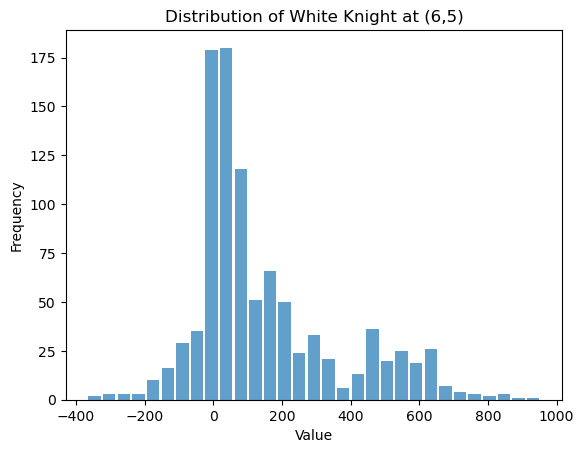

In [23]:
create_histogram(df[0][4][5][0],0,4,5,0)

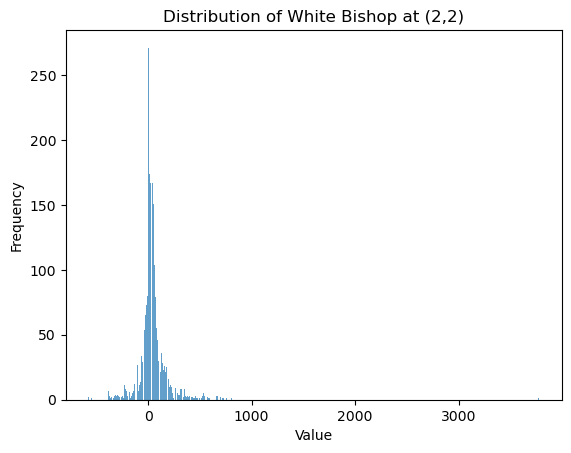

In [29]:
create_histogram(df[1][1][1][0],1,1,1,0)